In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gsw
import pdb
from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import Image
import matplotlib.colors as colors
from scipy.interpolate import griddata
import geopandas as gpd
from shapely.geometry import Point
from scipy.stats import gaussian_kde
import xarray as xr

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/xarray/conventions.py:9: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime


<IPython.core.display.Javascript object>


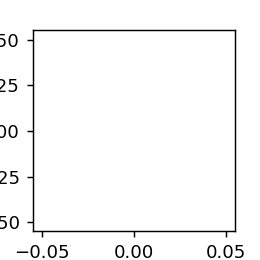

In [688]:
%matplotlib notebook
plt.figure(figsize=(2,2))
plt.plot()
plt.show()

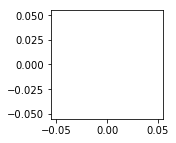

In [690]:
%matplotlib inline
plt.figure(figsize=(2,2))
plt.plot()
plt.show()

In [3]:
dfmg = pd.read_csv("dfmg_glDist.csv")
del dfmg['Unnamed: 0']
dfmg.loc[:,'JULD'] = pd.to_datetime(dfmg.loc[:, 'JULD'])

In [77]:
import plot_stations as pltStn
import importlib
importlib.reload(pltStn)

import plot_bathy as pltBathy
import importlib
importlib.reload(pltBathy)

import find_depth_averages_v2 as averageProfile
import plot_var_contours_with_distance as plt2dDepthVsDist

import plot_station_bot_sal as pbs

import plot_topView_contourf as topView
importlib.reload(topView)

import plot_monthly_count as monthCount
importlib.reload(monthCount)

import plot_theta_sal
importlib.reload(plot_theta_sal)

import plot_year_vs_salAverages as pltSalYearAvg
importlib.reload(pltSalYearAvg)

import plot_profiles_vs_dist as profDist

In [5]:
WSO_source = (dfmg['CTEMP'] <= -1.7 ) & (dfmg["PSAL_ADJUSTED"] > 34.5)
WSO_prod = (dfmg['CTEMP'] <= -0.8) & (dfmg['CTEMP'] >= -1.2) & (dfmg["PSAL_ADJUSTED"] > 34.5)

box1 = (dfmg["LATITUDE"] > -80) & (dfmg["LATITUDE"] < -75) & (dfmg["LONGITUDE"] > -60) & (dfmg["LONGITUDE"] < -40)
box2 = (dfmg["LATITUDE"] > -80) & (dfmg["LATITUDE"] < -75) & (dfmg["LONGITUDE"] > -40) & (dfmg["LONGITUDE"] < -20)
box3 = (dfmg["LATITUDE"] > -75) & (dfmg["LATITUDE"] < -70) & (dfmg["LONGITUDE"] > -60) & (dfmg["LONGITUDE"] < -40)
box4 = (dfmg["LATITUDE"] > -75) & (dfmg["LATITUDE"] < -70) & (dfmg["LONGITUDE"] > -40) & (dfmg["LONGITUDE"] < -20)

box5 = (dfmg["LATITUDE"] > -80) & (dfmg["LATITUDE"] < -75) & (dfmg["LONGITUDE"] > 160) & (dfmg["LONGITUDE"] < 180)
box6 = (dfmg["LATITUDE"] > -80) & (dfmg["LATITUDE"] < -75) & (dfmg["LONGITUDE"] > -180) & (dfmg["LONGITUDE"] < -160)
box7 = (dfmg["LATITUDE"] > -75) & (dfmg["LATITUDE"] < -70) & (dfmg["LONGITUDE"] > 160) & (dfmg["LONGITUDE"] < 180)
box8 = (dfmg["LATITUDE"] > -75) & (dfmg["LATITUDE"] < -70) & (dfmg["LONGITUDE"] > -180) & (dfmg["LONGITUDE"] < -160)

box9 = (dfmg["LATITUDE"] > -70) & (dfmg["LATITUDE"] < -65) & (dfmg["LONGITUDE"] > 60) & (dfmg["LONGITUDE"] < 70)
box10 = (dfmg["LATITUDE"] > -70) & (dfmg["LATITUDE"] < -65) & (dfmg["LONGITUDE"] > 70) & (dfmg["LONGITUDE"] < 80)

Weddell = (box1 | box2 | box3| box4)
Ross = (box5 | box6 | box7 | box8)
Prydz = (box9 | box10)
EBS = (dfmg['LONGITUDE'] > -80) & (dfmg['LONGITUDE'] < -60) #Eastern Bellingshausen Sea
WBS = (dfmg['LONGITUDE'] > -100) & (dfmg['LONGITUDE'] < -80) # Western Bellingshausen Sea

dfmg['mab'] = abs(dfmg['ECHODEPTH'] - dfmg['DEPTH'])
lt60 = abs(dfmg['mab']) < 60
lt100 = abs(dfmg['mab']) < 100
lt200 = abs(dfmg['mab']) < 200

lowSurfSal = (dfmg['PSAL_ADJUSTED'] < 33.5) & (dfmg['DEPTH'] > -100)
cdw = (dfmg['PSAL_ADJUSTED'] > 34.6) & (dfmg['CTEMP'] > 0)
maxTemp = (dfmg.groupby('PROFILE_NUMBER')['CTEMP'].transform(max) == dfmg['CTEMP'])
gline_le_50km = dfmg['DIST_GLINE'] <= 50
gline_le_100km = dfmg['DIST_GLINE'] <= 100
gline_le_150km = dfmg['DIST_GLINE'] <= 150
gline_le_25km = dfmg['DIST_GLINE'] <= 25
gline_le_75km = dfmg['DIST_GLINE'] <= 75

mask_theta_sal_not_nan = ~(dfmg.loc[:, 'CTEMP'].isnull() + dfmg.loc[:, 'PSAL_ADJUSTED'].isnull())

deep_mask = dfmg['deep_flag'] == 1.0
deep_mask = deep_mask + (dfmg['ECHODEPTH'] < 100)

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  unsupported[op_str]))


In [6]:
year_mask = []
years = np.sort(dfmg['JULD'].dt.year.unique())
for i in range(len(years)):
    mask = dfmg['JULD'].dt.year == years[i]
    year_mask.append(mask)
month_mask = []
for i in range(12):
    mask = dfmg['JULD'].dt.month == i+1
    month_mask.append(mask)
    
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [7]:
def sel_months(df, months=[1]):
    return df['JULD'].dt.month.isin(months)

def get_mask_from_prof_mask(df, profmask):
    profs = dfmg.loc[profmask, 'PROFILE_NUMBER'].unique()
    mask = dfmg.loc[:, 'PROFILE_NUMBER'].isin(profs)
    
    return mask

def play_beep():
    import os
    duration = 1  # second
    freq = 440  # Hz
    os.system('play --no-show-progress --null --channels 1 synth %s sine %f' % (duration, freq))

## $\theta$ - S profiles - All Data

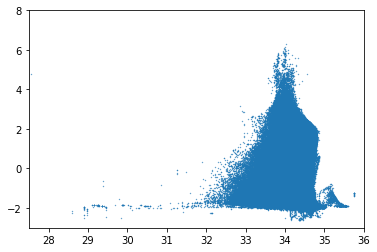

In [8]:
all_thetas = dfmg.loc[:, 'CTEMP']
all_sals = dfmg.loc[:, 'PSAL_ADJUSTED']
plt.scatter(all_sals, all_thetas, s=0.1)
plt.xlim(27.5, 36)
plt.ylim(-3, 8)
plt.show()

## $\theta$ - S profiles - Weddell Sea

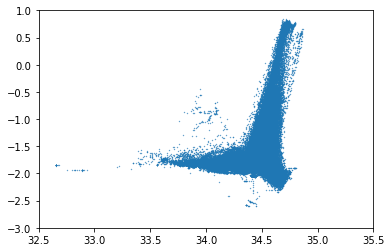

In [63]:
thetas = dfmg.loc[Weddell & mask_theta_sal_not_nan, 'CTEMP']
sals = dfmg.loc[Weddell & mask_theta_sal_not_nan, 'PSAL_ADJUSTED']

plt.scatter(sals, thetas, s=0.1)
plt.xlim(32.5, 35.5)
plt.ylim(-3, 1)
plt.show()

#### Year-wise $\theta$-S plots

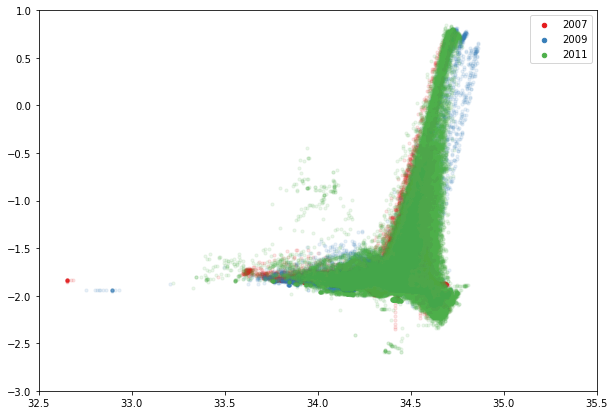

In [20]:
plot_theta_sal.plot_theta_s_yearly(dfmg, Weddell, years=[2007, 2009, 2011], alpha=0.1, s=10, wd=10, ht=7)

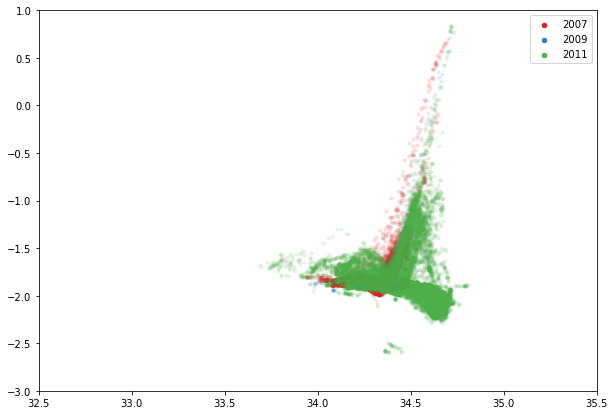

In [17]:
thetas = dfmg.loc[Weddell & gline_le_150km & mask_theta_sal_not_nan, 'CTEMP']
sals = dfmg.loc[Weddell & gline_le_150km & mask_theta_sal_not_nan, 'PSAL_ADJUSTED']

plot_theta_sal.plot_theta_s_yearly(dfmg, Weddell&gline_le_150km, years=[2007, 2009, 2011], alpha=0.1, wd=10, ht=7, 
                                   s=10)

## $\theta$ - S profiles - Ross Sea

In [498]:
importlib.reload(plot_theta_sal)

<module 'plot_theta_sal' from '/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_theta_sal.py'>

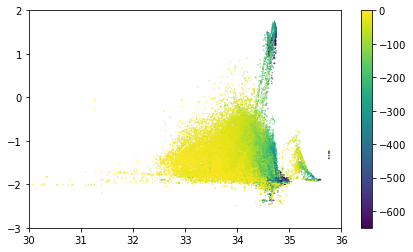

In [499]:
plot_theta_sal.plot_theta_s(dfmg, Ross, thetamax=2, alpha=1)

In [503]:
12//5

2

In [485]:
mask = dfmg[Ross].groupby('PROFILE_NUMBER').tail(1).index
dfmg[Ross].loc[mask].groupby(pd.cut(dfmg[Ross].loc[mask].DEPTH, depth_buckets)).JULD.count()

DEPTH
(-3000, -1000]       1
(-1000, -950]        2
(-950, -900]         2
(-900, -850]         8
(-850, -800]        23
(-800, -750]        46
(-750, -700]        68
(-700, -650]        94
(-650, -600]       126
(-600, -550]       263
(-550, -500]       521
(-500, -450]       769
(-450, -400]       907
(-400, -350]      1133
(-350, -300]      1318
(-300, -250]      1368
(-250, -200]      1368
(-200, -150]      1440
(-150, -100]      1131
(-100, -50]        630
(-50, 0]           110
Name: JULD, dtype: int64

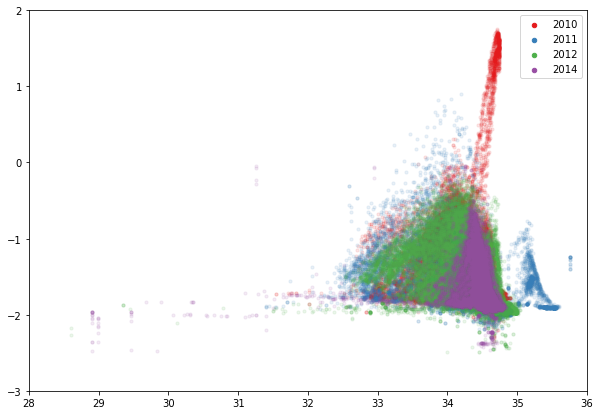

In [29]:
plot_theta_sal.plot_theta_s_yearly(dfmg, Ross, salmin=28, salmax=36, tempmax=2, 
                                   years=[2010, 2011, 2012, 2014], alpha=0.1, wd=10, ht=7, 
                                   s=10)

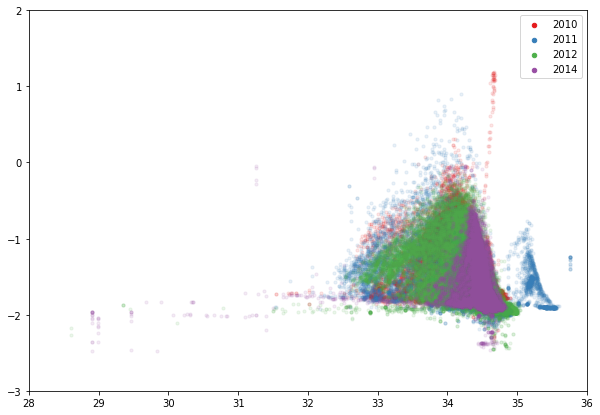

In [28]:
plot_theta_sal.plot_theta_s_yearly(dfmg, Ross&gline_le_150km, salmin=28, salmax=36, tempmax=2, 
                                   years=[2010, 2011, 2012, 2014], alpha=0.1, wd=10, ht=7, 
                                   s=10)

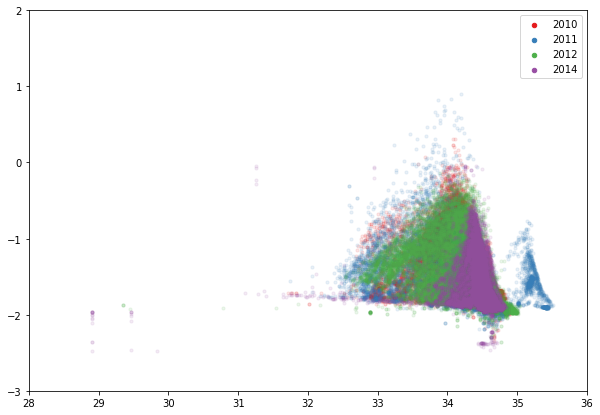

In [30]:
plot_theta_sal.plot_theta_s_yearly(dfmg, Ross&gline_le_50km, salmin=28, salmax=36, tempmax=2, 
                                   years=[2010, 2011, 2012, 2014], alpha=0.1, wd=10, ht=7, 
                                   s=10)

In [31]:
dfmg.columns

Index(['JULD', 'LATITUDE', 'LONGITUDE', 'PLATFORM_NUMBER', 'POSITION_QC',
       'PRES_ADJUSTED', 'PRES_ADJUSTED_QC', 'PROFILE_NUMBER', 'PSAL_ADJUSTED',
       'PSAL_ADJUSTED_QC', 'TEMP_ADJUSTED', 'TEMP_ADJUSTED_QC', 'DEPTH',
       'DENSITY_INSITU', 'POT_DENSITY', 'CTEMP', 'DENSITY_GRADIENT',
       'ECHODEPTH', 'mab', 'deep_flag', 'DIST_GLINE'],
      dtype='object')

In [44]:
import find_depth_averages_v2
importlib.reload(find_depth_averages_v2)

<module 'find_depth_averages_v2' from '/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/find_depth_averages_v2.py'>

/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/find_depth_averages_v2.py:107: RuntimeWarning: invalid value encountered in less
  xerror = ma.array(xerror, mask=(xerror < 0))


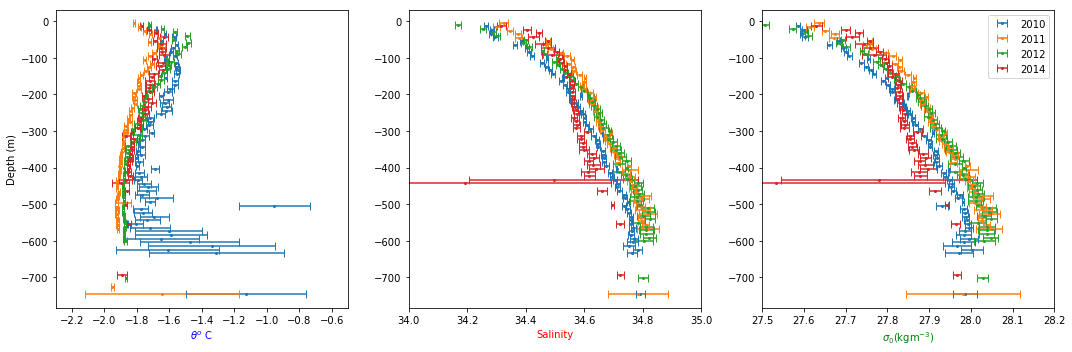

In [111]:
find_depth_averages_v2.plot_depth_averages_yearwise(dfmg, Ross, 
                                                    years=[2010, 2011, 2012, 2014], sigmin=27.5, 
                                                    sigmax=28.2, salmin=34, salmax=35, wd=15)

/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/find_depth_averages_v2.py:107: RuntimeWarning: invalid value encountered in less
  xerror = ma.array(xerror, mask=(xerror < 0))


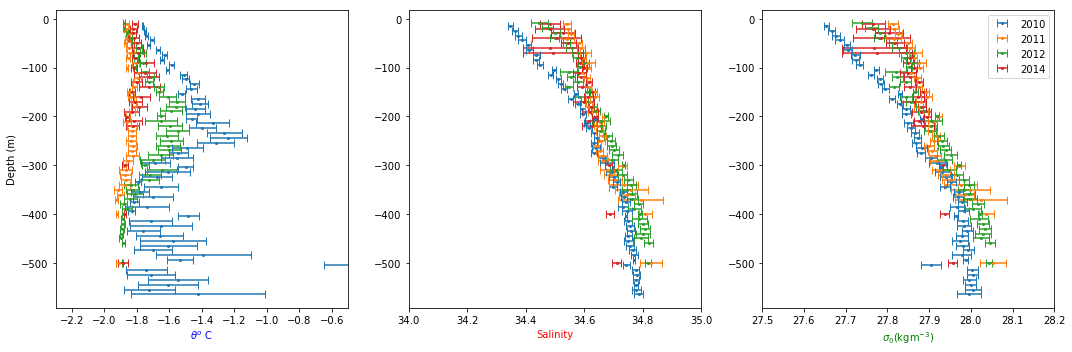

In [112]:
find_depth_averages_v2.plot_depth_averages_yearwise(dfmg, Ross &~(gline_le_100km), 
                                                    years=[2010, 2011, 2012, 2014], sigmin=27.5, 
                                                    sigmax=28.2, salmin=34, salmax=35, wd=15)

<IPython.core.display.Javascript object>


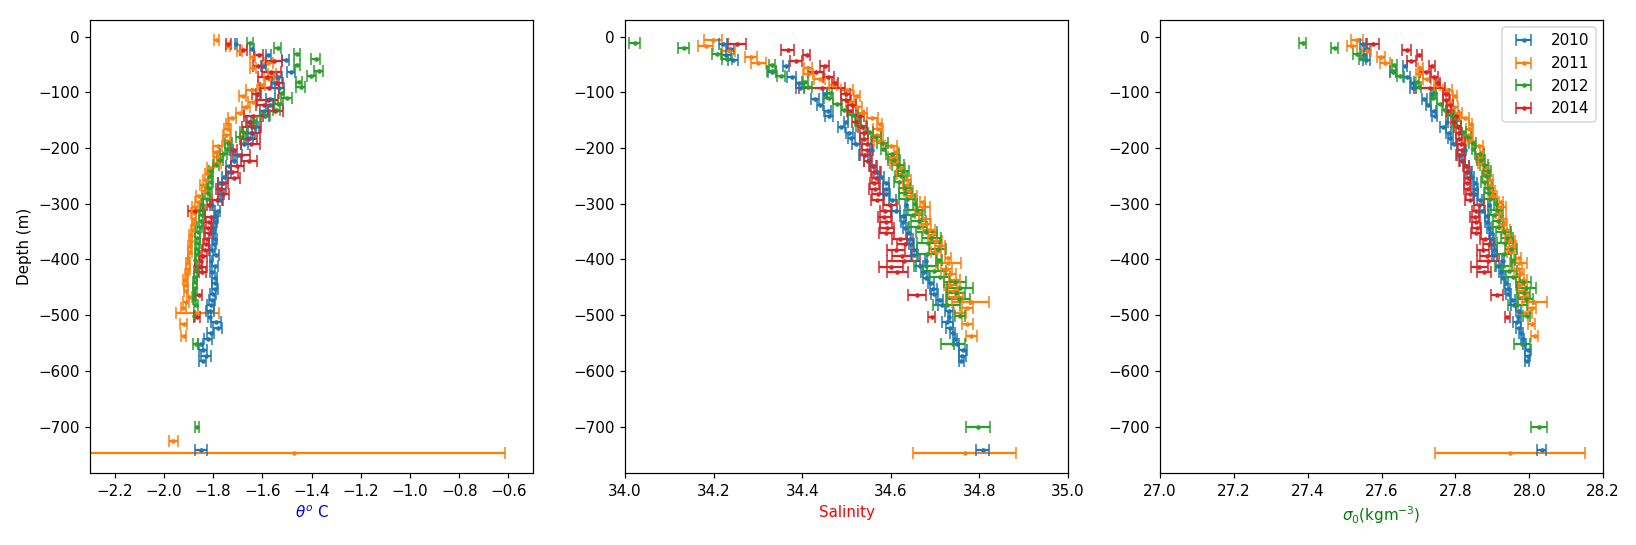

/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/find_depth_averages_v2.py:107: RuntimeWarning: invalid value encountered in less
  xerror = ma.array(xerror, mask=(xerror < 0))


In [121]:
find_depth_averages_v2.plot_depth_averages_yearwise(dfmg, Ross & (gline_le_50km), 
                                                    years=[2010, 2011, 2012, 2014], sigmin=27., 
                                                    sigmax=28.2, salmin=34, salmax=35, wd=15)

## Bottom Salinities

#### Ross Sea, Bottom Salinity

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/numpy/core/numeric.py:531: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


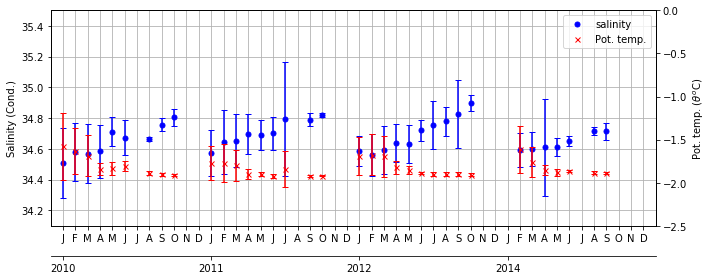

In [817]:
pltSalYearAvg.get_bottom_theta_sal_averages_vs_year(dfmg, Ross&gline_le_75km&deep_mask, 
                                              years=[2010, 2011, 2012, 2014], markersize=5, 
                                              save=True, savename="./Images/RossBotSal_GLle75km.png", salmin=34.1,
                                                   salmax=35.5, thetamin=-2.5, thetamax=0)

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/numpy/core/numeric.py:531: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


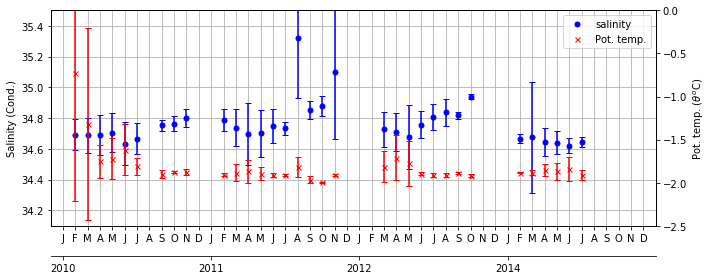

In [818]:
pltSalYearAvg.get_bottom_theta_sal_averages_vs_year(dfmg, Ross&~gline_le_75km&deep_mask, 
                                              years=[2010, 2011, 2012, 2014], markersize=5, save=True, 
                                            savename="./Images/RossBotSal_Xclude_GLle75km.png", salmin=34.1,
                                                   salmax=35.5, thetamin=-2.5, thetamax=0)

#### Weddell Sea, Bottom Salinity

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/numpy/core/numeric.py:531: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


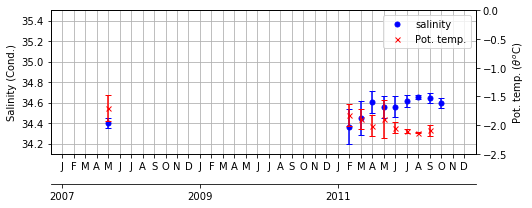

In [819]:
pltSalYearAvg.get_bottom_theta_sal_averages_vs_year(dfmg, Weddell&gline_le_75km&deep_mask, 
                                              years=[2007, 2009, 2011], markersize=5, save=True, 
                                              savename="./Images/WeddellBotSal_GLle75km.png", wd=10.*3./4., 
                                                    ht=4.*3./4., salmin=34.1,
                                                   salmax=35.5, thetamin=-2.5, thetamax=0)

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/numpy/core/numeric.py:531: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


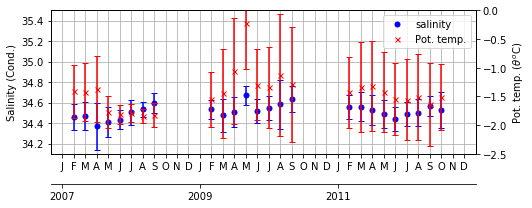

In [820]:
pltSalYearAvg.get_bottom_theta_sal_averages_vs_year(dfmg, Weddell&~gline_le_75km, 
                                              years=[2007, 2009, 2011], markersize=5, save=True, 
                                              savename="./Images/WeddellBotSal_Xclude_GLle75km.png", wd=10.*3./4., 
                                                    ht=4.*3./4., salmin=34.1,
                                                   salmax=35.5, thetamin=-2.5, thetamax=0)

#### Prydz Bay bottom salinity

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/numpy/core/numeric.py:531: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


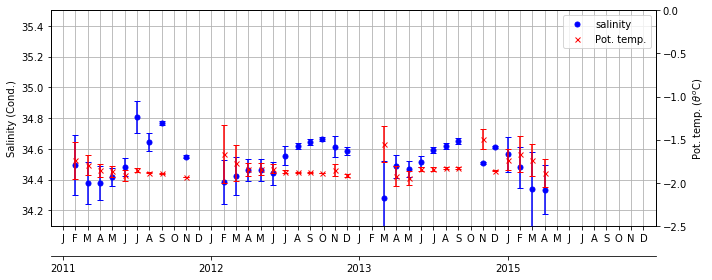

In [821]:
pltSalYearAvg.get_bottom_theta_sal_averages_vs_year(dfmg, Prydz&gline_le_75km, 
                                              years=[2011, 2012, 2013, 2015], markersize=5, wd=10, ht=4, save=True,
                                             savename="./Images/PrydzBotSal_GLle75km.png", salmin=34.1,
                                                   salmax=35.5, thetamin=-2.5, thetamax=0)

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/numpy/core/numeric.py:531: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


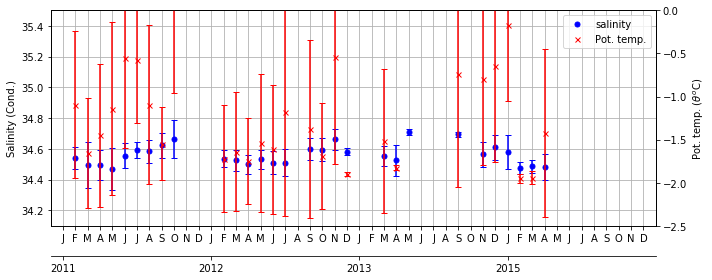

In [822]:
pltSalYearAvg.get_bottom_theta_sal_averages_vs_year(dfmg, Prydz&deep_mask&~gline_le_75km, 
                                              years=[2011, 2012, 2013, 2015], markersize=5, wd=10,ht=4, save=True,
                                             savename="./Images/PrydzBotSal_Xclude_GLle75km.png", salmin=34.1,
                                                   salmax=35.5, thetamin=-2.5, thetamax=0)

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  unsupported[op_str]))


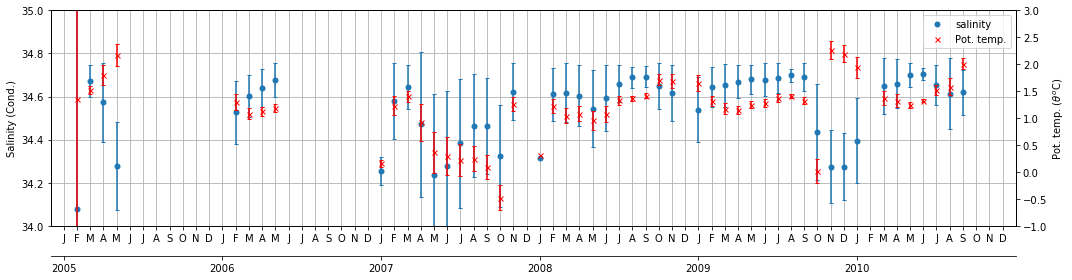

In [550]:
pltSalYearAvg.get_bottom_theta_sal_averages_vs_year(dfmg, EBS+WBS, 
                                              years=[2005, 2006, 2007, 2008, 2009, 2010], markersize=5, wd=15, 
                                                    save=True,
                                             savename="./Images/BSbotSal.png", salmin=34.,
                                                   salmax=35., thetamin=-1., thetamax=3.)

## Surface Salinities

In [917]:
importlib.reload(pltSalYearAvg)

<module 'plot_year_vs_salAverages' from '/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_year_vs_salAverages.py'>

11.958699187786596 1027.99528863 34.8972988987 1027.07837163 33.7739340784
11.958699187786596 1027.98133165 34.8754811034 1027.00715616 33.6822657235
11.958699187786596 1027.9934967 34.896014695 1026.85145186 33.5150240375
11.958699187786596 1027.99165522 34.863617132 1027.2590942 34.0009622107


/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/numpy/core/numeric.py:531: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


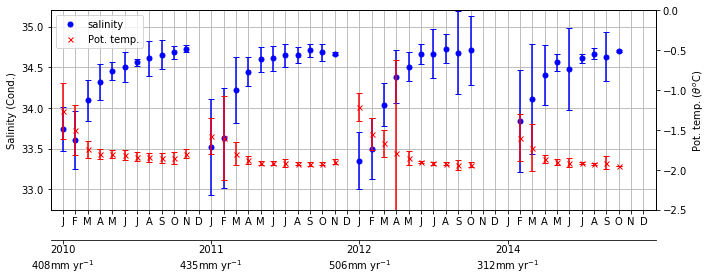

In [918]:
pltSalYearAvg.get_surface_theta_sal_averages_vs_year(dfmg, Ross&gline_le_75km, 
                                              years=[2010, 2011, 2012, 2014], markersize=5, save=True, 
                                                    savename="./Images/RossSurfSalGLle75km.png", salmin=32.75,
                                                    salmax=35.2, thetamin=-2.5, thetamax=0)

In [909]:
dfmg.groupby("PROFILE_NUMBER").head(1).DEPTH.mean() * 2.

-13.770256118783585

In [910]:
dfmg.groupby("PROFILE_NUMBER").head(1).DEPTH.median() * 2.

-11.880608395179296

11.894863326238244 1027.95674379 34.8495672311 1027.26404434 34.0089776994
11.894863326238244 1028.14886221 35.082256318 1027.30450251 34.1094128383
11.894863326238244 1028.00989912 34.9224254409 1027.21630908 33.9493988864
11.894863326238244 1027.96004551 34.8255224179 1027.66427006 34.5353830881


/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/numpy/core/numeric.py:531: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


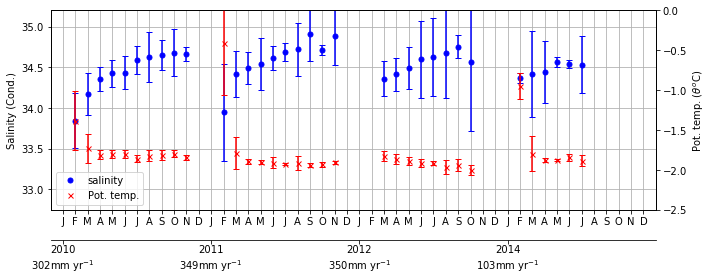

In [919]:
pltSalYearAvg.get_surface_theta_sal_averages_vs_year(dfmg, Ross&~gline_le_75km, 
                                              years=[2010, 2011, 2012, 2014], markersize=5, save=True, 
                                                    savename="./Images/RossSurfSal_Xclude_GLle75km.png", salmin=32.75,
                                                    salmax=35.2, thetamin=-2.5, thetamax=0)

15.832959347337471 1027.60510267 34.3992904351 1027.60510267 34.3992904351
15.832959347337471 1027.88187723 34.7471653801 1027.34209054 34.080248956


/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/numpy/core/numeric.py:531: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


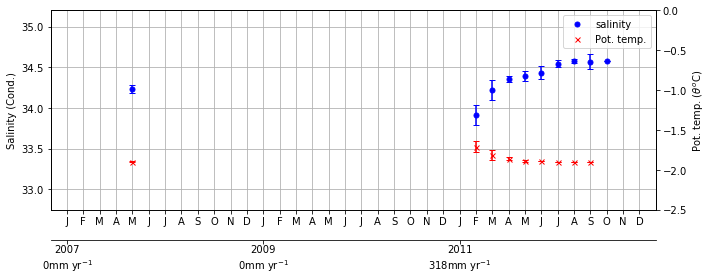

In [920]:
pltSalYearAvg.get_surface_theta_sal_averages_vs_year(dfmg, Weddell&gline_le_75km&deep_mask, 
                                              years=[2007, 2009, 2011], markersize=5, save=True,
                                                    savename="./Images/WeddellSurfSalGLle75km.png", salmin=32.75,
                                                    salmax=35.2, thetamin=-2.5, thetamax=0)

15.833800069667083 1027.9208058 34.7902139932 1027.34948834 34.0860049771
15.833800069667083 1027.85934599 34.7119270903 1027.47302062 34.2387093473
15.833800069667083 1027.81517301 34.6411561259 1027.42998189 34.1868858494


/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/numpy/core/numeric.py:531: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


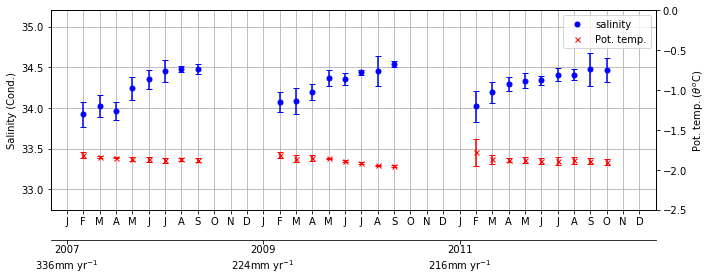

In [921]:
pltSalYearAvg.get_surface_theta_sal_averages_vs_year(dfmg, Weddell&~gline_le_75km, 
                                              years=[2007, 2009, 2011], markersize=5, save=True,
                                                    savename="./Images/WeddellSurfSal_Xclude_GLle75km.png", salmin=32.75,
                                                    salmax=35.2, thetamin=-2.5, thetamax=0)

11.818316476497795 1027.90722025 34.7857401515 1027.125028 33.8376394695
11.818316476497795 1027.92428394 34.8063011946 1027.0255137 33.7179832432
11.818316476497795 1027.93256807 34.8258455763 1027.30253446 34.0416441291
11.818316476497795 1027.48558382 34.2729941641 1026.84933534 33.5396429426


/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/numpy/core/numeric.py:531: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


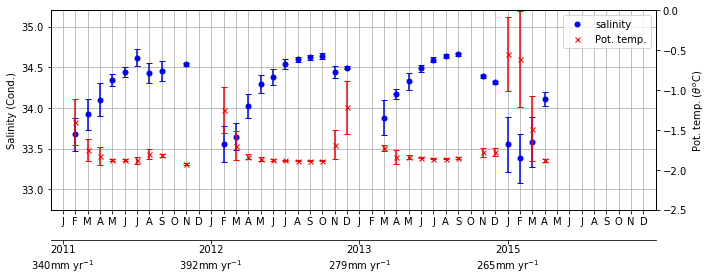

In [922]:
importlib.reload(pltSalYearAvg)
pltSalYearAvg.get_surface_theta_sal_averages_vs_year(dfmg, Prydz&gline_le_75km, 
                                              years=[2011, 2012, 2013, 2015], markersize=5, wd=10, ht=4, save=True,
                                                    savename="./Images/PrydzSurfSalGLle75km.png", salmin=32.75,
                                                    salmax=35.2, thetamin=-2.5, thetamax=0)

11.631175750624971 1027.6661642 34.4963009064 1027.07351919 33.782001842
11.631175750624971 1027.81118368 34.6664544302 1027.21143912 33.9725117085
11.631175750624971 1027.81339958 34.6799632678 1027.34238669 34.1003964292
11.631175750624971 1027.40181338 34.167949834 1026.46835046 33.0977497031


/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/numpy/core/numeric.py:531: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


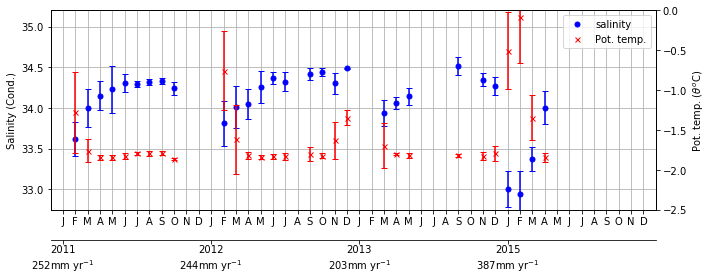

In [923]:
pltSalYearAvg.get_surface_theta_sal_averages_vs_year(dfmg, Prydz&~gline_le_75km, 
                                              years=[2011, 2012, 2013, 2015], markersize=5, wd=10, ht=4, save=True,
                                                    savename="./Images/PrydzSurfSal_Xclude_GLle75km.png", salmin=32.75,
                                                    salmax=35.2, thetamin=-2.5, thetamax=0)

In [345]:
ICE = xr.open_dataset("/media/data/Datasets/SeaIce/HadISST/HadISST_ice.nc")

In [368]:
def get_seaIceConc(ICE, timemin, timemax, latmin, latmax, lonmin, lonmax):
    timeStart = np.asscalar(np.argmin(np.abs(ICE['time'] - timemin)).values)
    timeEnd = np.asscalar(np.argmin(np.abs(ICE['time'] - timemax)).values)
    
    latStart = np.asscalar(np.argmin(np.abs(ICE['latitude'] - latmax)).values)
    latEnd = np.asscalar(np.argmin(np.abs(ICE['latitude'] - latmin)).values)
    
    lonStart = np.asscalar(np.argmin(np.abs(ICE['longitude'] - lonmin)).values)
    lonEnd = np.asscalar(np.argmin(np.abs(ICE['longitude'] - lonmax)).values)
    
    return timeStart, timeEnd, latStart, latEnd, lonStart, lonEnd

In [373]:
time = np.arange('2006-02', '2006-10', dtype='datetime64[M]')
latmin = -90
latmax = -60
lonmin = -70
lonmax = -11

timeS, timeE, latS, latE, lonS, lonE = get_seaIceConc(ICE, time[0], time[-1], latmin, latmax, lonmin, lonmax)

In [492]:
import cartopy.crs as ccrs

In [493]:
sic = ICE.sic

IllegalArgumentException: Invalid number of points in LinearRing found 3 - must be 0 or >= 4
Shell is not a LinearRing
IllegalArgumentException: Invalid number of points in LinearRing found 3 - must be 0 or >= 4
Shell is not a LinearRing
IllegalArgumentException: Invalid number of points in LinearRing found 3 - must be 0 or >= 4
Shell is not a LinearRing
IllegalArgumentException: Invalid number of points in LinearRing found 3 - must be 0 or >= 4
Shell is not a LinearRing


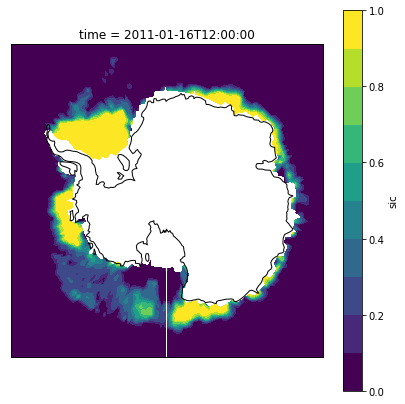

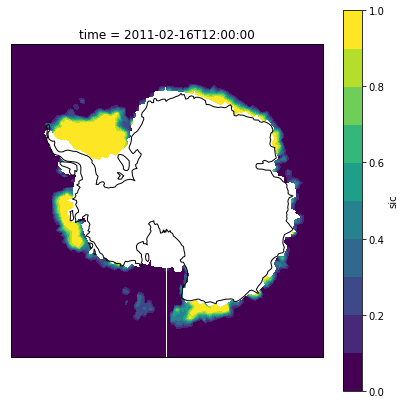

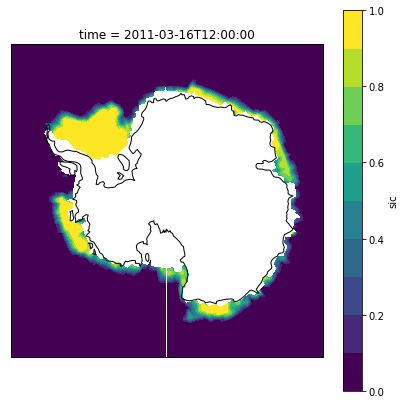

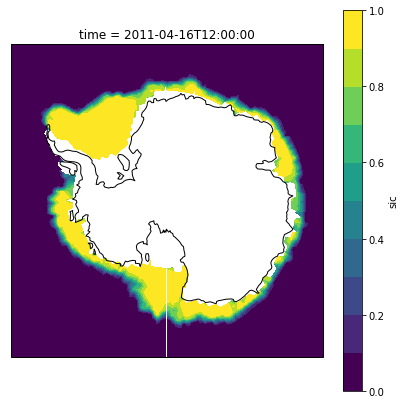

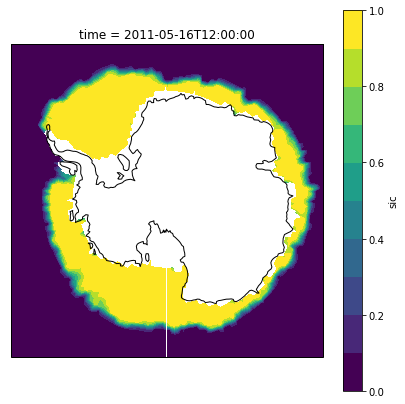

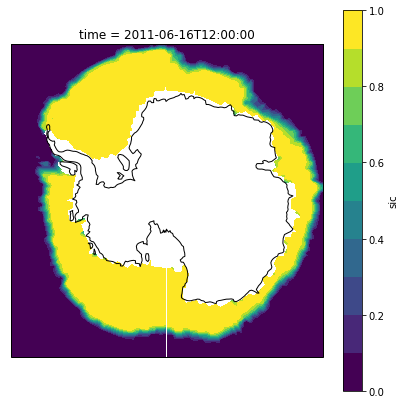

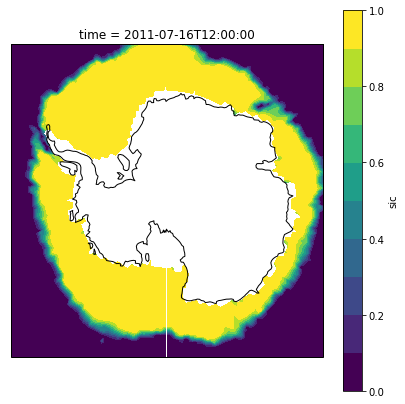

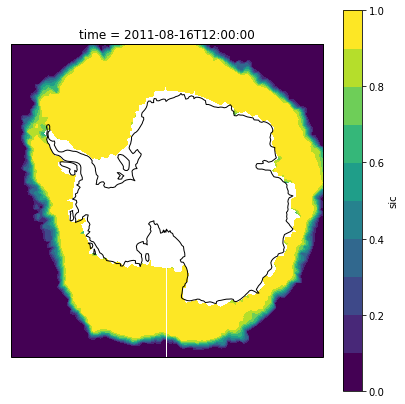

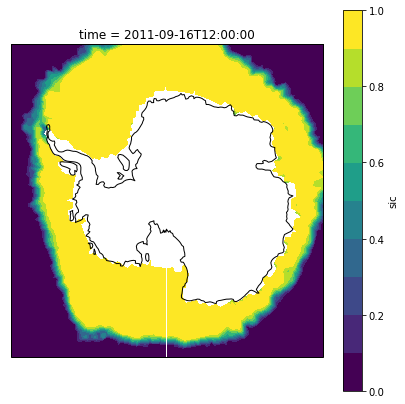

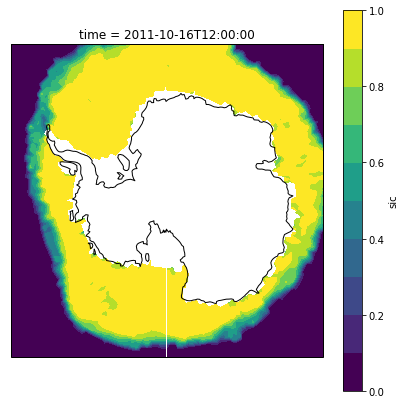

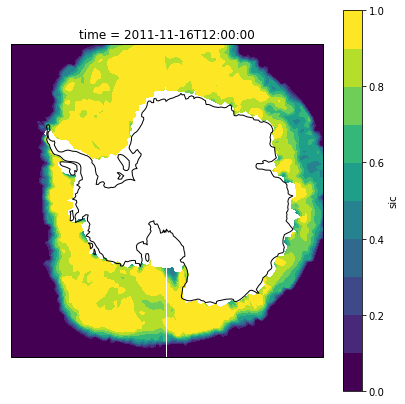

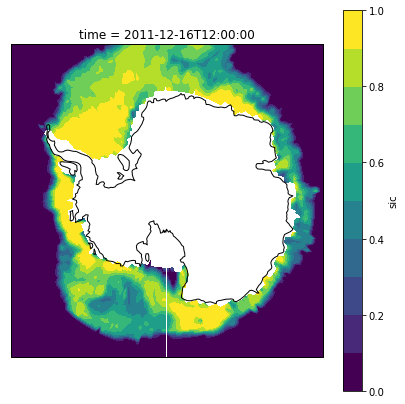

In [541]:
importlib.reload(topView)
time = np.arange('2011-02', '2012-02', dtype='datetime64[M]')
for i in range(len(time)):
    timeind = np.asscalar(np.argmin(np.abs(ICE['time'] - time[i])).values)
    topView.plotSeaIceConc(ICE, timeind, show=False, save=True, 
                           savename="./Images/SIC/2011_"+str(month_names[i])+".png")

In [542]:
for i in range(1,10,1):
    topView.plotDataDensity(dfmg.loc[Weddell & deep_mask & year_mask[7] & month_mask[i]], save=True, 
            savename="./Images/dataDensityWeddell2011Monthwise/dataDensityWeddell2011"+str(month_names[i])+".png", 
            wd=10, ht=10, nx=300, ny=300, region='Weddell', levels=[0,10,20,30,40,50])

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3677: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


<IPython.core.display.Javascript object>


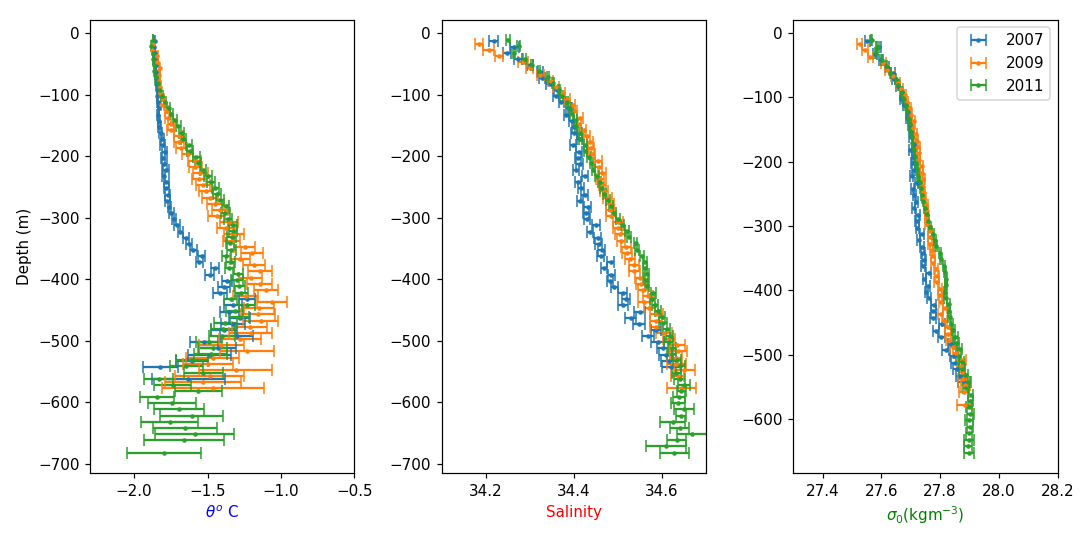

/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/find_depth_averages_v2.py:107: RuntimeWarning: invalid value encountered in less
  xerror = ma.array(xerror, mask=(xerror < 0))


In [108]:
find_depth_averages_v2.plot_depth_averages_yearwise(dfmg, Weddell & (~gline_le_100km), years=[2007, 2009, 2011], 
                                                    sigmin=27.3, 
                                                    sigmax=28.2, salmin=34.1, salmax=34.7, wd=10, min_n=25)

<IPython.core.display.Javascript object>


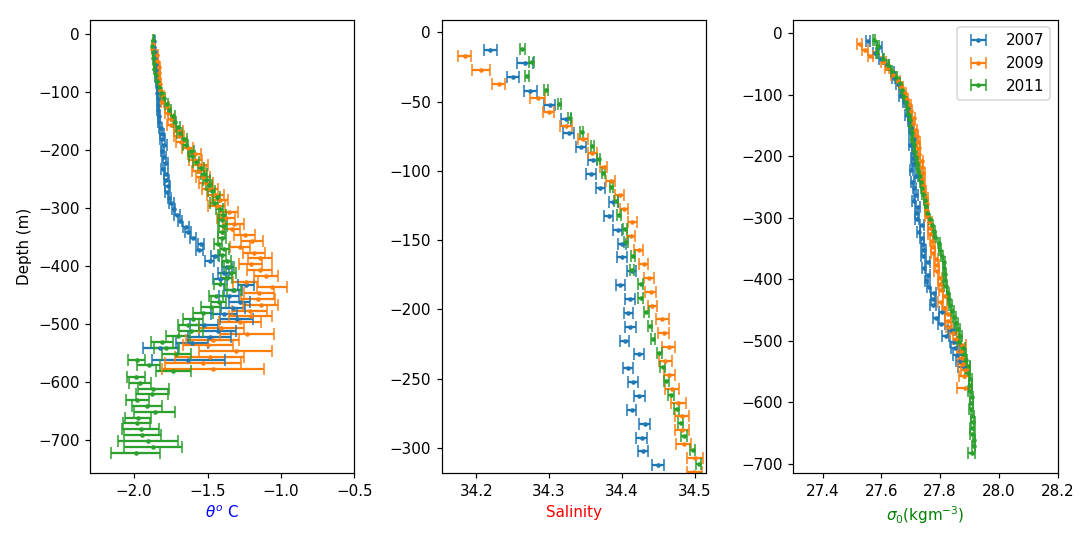

/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/find_depth_averages_v2.py:107: RuntimeWarning: invalid value encountered in less
  xerror = ma.array(xerror, mask=(xerror < 0))


In [107]:
find_depth_averages_v2.plot_depth_averages_yearwise(dfmg, Weddell, years=[2007, 2009, 2011], sigmin=27.3, 
                                                    sigmax=28.2, salmin=34.1, salmax=34.7, wd=10, min_n=25)

<IPython.core.display.Javascript object>


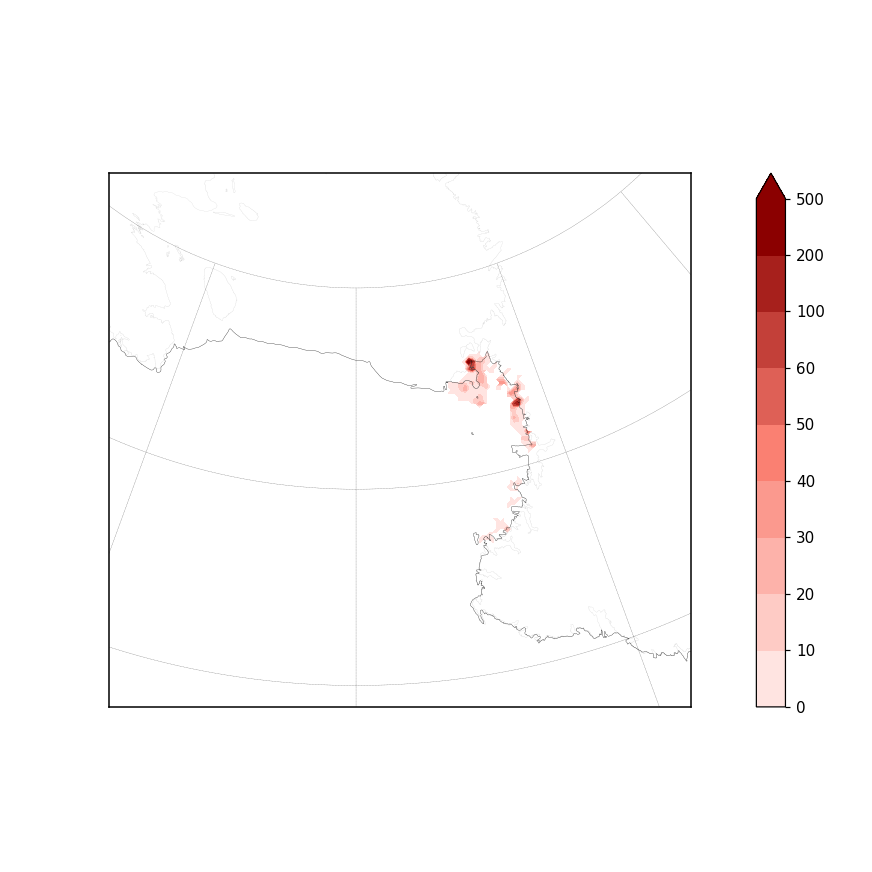

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3677: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


In [120]:
var = 'PSAL_ADJUSTED'
dfno = dfmg.loc[~dfmg.loc[:, var].isnull() & year_mask[7] & gline_le_50km]
levels = [0, 10, 20, 30, 40, 50, 60, 100, 200, 500] #, 90, 150, 250, 500, 1000, 2500]
topView.plotDataDensity(dfno, wd=8, ht=8, nx=820, ny=820, levels=levels, 
                        save=False, show=True)

0 0


/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_monthly_count.py:60: RuntimeWarning: invalid value encountered in true_divide
  rects_source = ax_sp.bar(np.arange(12)+wd, nprof_source/nprof_all*100, wd, color='r', label='source')
/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_monthly_count.py:61: RuntimeWarning: invalid value encountered in true_divide
  rects_prod = ax_sp.bar(np.arange(12)+wd*2, nprof_prod/nprof_all*100, wd, color='b', label='prod')


0 1
0 2
0 3


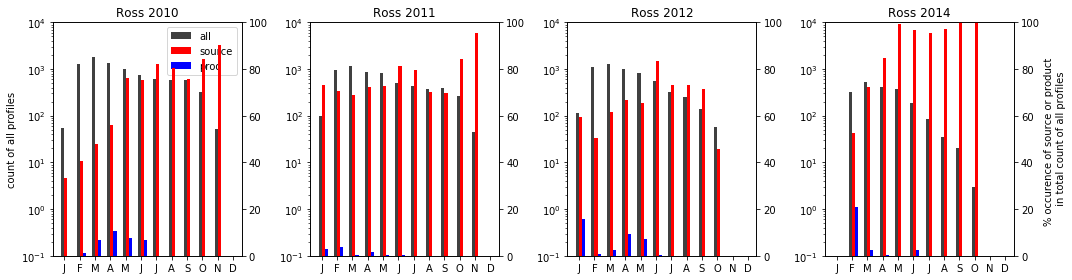

In [58]:
monthCount.plot_counts_profs(dfmg, WSO_source, WSO_prod, 
                             boxes=[Ross&year_mask[6], Ross&year_mask[7], Ross&year_mask[8], Ross&year_mask[10]], 
                             row=1, col=4, titles=['Ross 2010','Ross 2011', 'Ross 2012', 'Ross 2014'], ht=4, wd=15)

In [67]:
monthCount.plot_counts_profs(dfmg, WSO_source, WSO_prod, 
                             boxes=[Ross&year_mask[6], Ross&year_mask[7], Ross&year_mask[8], Ross&year_mask[10]], 
                             row=1, col=4, titles=['Ross 2010','Ross 2011', 'Ross 2012', 'Ross 2014'], ht=4, wd=15)

array([2007, 2008, 2009, 2010, 2011])

0 0


/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_monthly_count.py:60: RuntimeWarning: invalid value encountered in true_divide
  rects_source = ax_sp.bar(np.arange(12)+wd, nprof_source/nprof_all*100, wd, color='r', label='source')
/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_monthly_count.py:61: RuntimeWarning: invalid value encountered in true_divide
  rects_prod = ax_sp.bar(np.arange(12)+wd*2, nprof_prod/nprof_all*100, wd, color='b', label='prod')


0 1
0 2


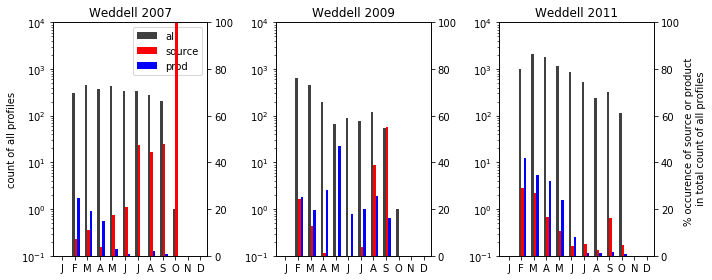

In [283]:
region = Weddell & ~gline_le_100km
monthCount.plot_counts_profs(dfmg, WSO_source, WSO_prod, 
                             boxes=[region&year_mask[3],  region&year_mask[5], region&year_mask[7]],
                             row=1, col=3, titles=['Weddell 2007', 'Weddell 2009', 'Weddell 2011'], ht=4, wd=10)

In [559]:
years[2]

2006

In [568]:
dfmg.loc[dfmg.loc[region&year_mask[3]].groupby('PROFILE_NUMBER').tail(1).index, 'PLATFORM_NUMBER'].unique()

array(["b'00012048'", "b'00012054'", "b'00012060'", "b'00012192'"], dtype=object)

0 0


/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_monthly_count.py:60: RuntimeWarning: invalid value encountered in true_divide
  rects_source = ax_sp.bar(np.arange(12)+wd, nprof_source/nprof_all*100, wd, color='r', label='source')
/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_monthly_count.py:61: RuntimeWarning: invalid value encountered in true_divide
  rects_prod = ax_sp.bar(np.arange(12)+wd*2, nprof_prod/nprof_all*100, wd, color='b', label='prod')


0 1
0 2
1 0
1 1
1 2


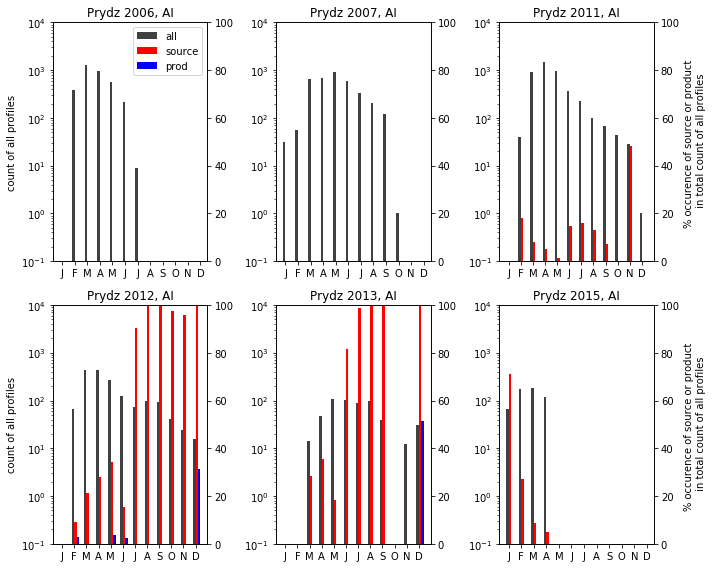

In [165]:
importlib.reload(monthCount)
region = Prydz & gline_le_75km
monthCount.plot_counts_profs(dfmg, WSO_source, WSO_prod, 
                             boxes=[region&year_mask[2],  region&year_mask[3], region&year_mask[7], 
                                   region&year_mask[8], region&year_mask[9], region&year_mask[11]],
                             row=2, col=3, titles=['Prydz 2006, AI', 'Prydz 2007, AI', 'Prydz 2011, AI', 
                                                  'Prydz 2012, AI', 'Prydz 2013, AI', 'Prydz 2015, AI'], ht=8, wd=10)

0 0


/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_monthly_count.py:60: RuntimeWarning: invalid value encountered in true_divide
  rects_source = ax_sp.bar(np.arange(12)+wd, nprof_source/nprof_all*100, wd, color='r', label='source')
/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_monthly_count.py:61: RuntimeWarning: invalid value encountered in true_divide
  rects_prod = ax_sp.bar(np.arange(12)+wd*2, nprof_prod/nprof_all*100, wd, color='b', label='prod')


0 1
0 2
1 0
1 1
1 2


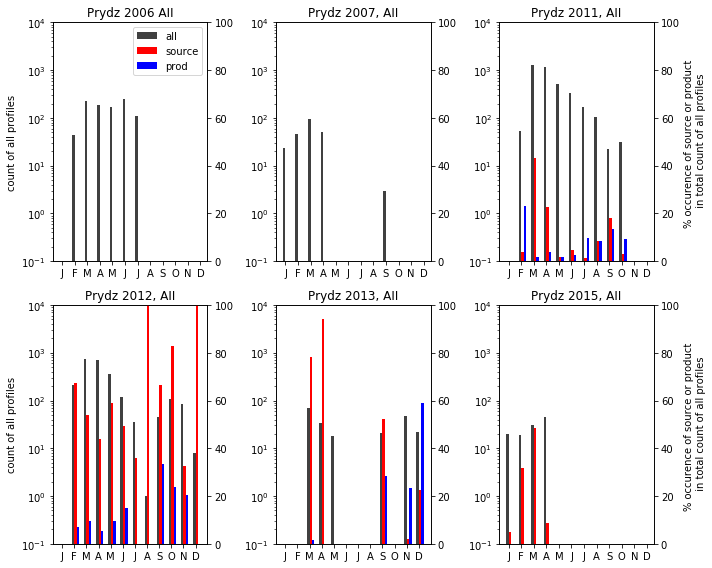

In [164]:
importlib.reload(monthCount)
region = Prydz & ~gline_le_75km
monthCount.plot_counts_profs(dfmg, WSO_source, WSO_prod, 
                             boxes=[region&year_mask[2],  region&year_mask[3], region&year_mask[7], 
                                   region&year_mask[8], region&year_mask[9], region&year_mask[11]],
                             row=2, col=3, titles=['Prydz 2006 AII', 'Prydz 2007, AII', 'Prydz 2011, AII', 
                                                  'Prydz 2012, AII', 'Prydz 2013, AII', 'Prydz 2015, AII'], 
                             ht=8, wd=10)

## $\theta$ - S profiles - Prydz Bay

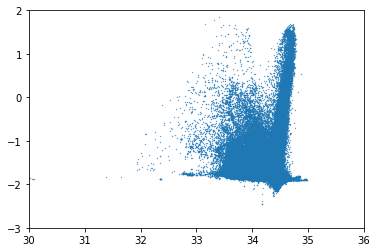

In [66]:
all_thetas = dfmg.loc[Prydz, 'CTEMP']
all_sals = dfmg.loc[Prydz, 'PSAL_ADJUSTED']
plt.scatter(all_sals, all_thetas, s=0.1)
plt.xlim(30, 36)
plt.ylim(-3, 2)
plt.show()

## $\theta$ - S profiles - Bellingshaussen Sea

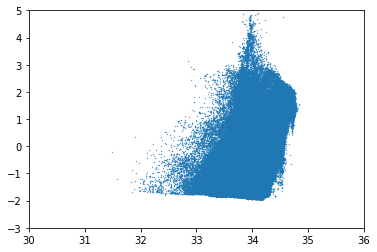

In [68]:
all_thetas = dfmg.loc[EBS, 'CTEMP']
all_sals = dfmg.loc[EBS, 'PSAL_ADJUSTED']
plt.scatter(all_sals, all_thetas, s=0.1)
plt.xlim(30, 36)
plt.ylim(-3, 5)
plt.show()

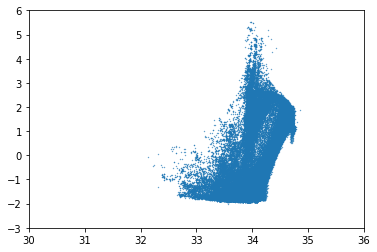

In [71]:
all_thetas = dfmg.loc[WBS, 'CTEMP']
all_sals = dfmg.loc[WBS, 'PSAL_ADJUSTED']
plt.scatter(all_sals, all_thetas, s=0.1)
plt.xlim(30, 36)
plt.ylim(-3, 6)
plt.show()

In [112]:
importlib.reload(plot_theta_sal)

<module 'plot_theta_sal' from '/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_theta_sal.py'>

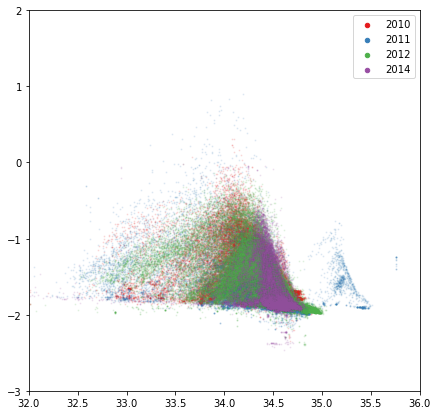

In [55]:
plot_theta_sal.plot_theta_s_yearly(dfmg, Ross&gline_le_75km, salmin=32, salmax=36, tempmax=2,
                                   years=[2010, 2011, 2012, 2014], alpha=0.1)

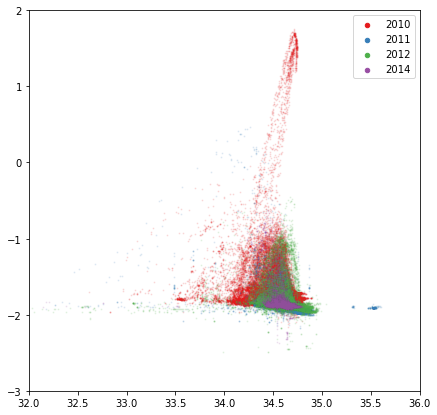

In [60]:
plot_theta_sal.plot_theta_s_yearly(dfmg, Ross&~gline_le_75km, salmin=32, salmax=36, tempmax=2,
                                   years=[2010, 2011, 2012, 2014], alpha=0.1)

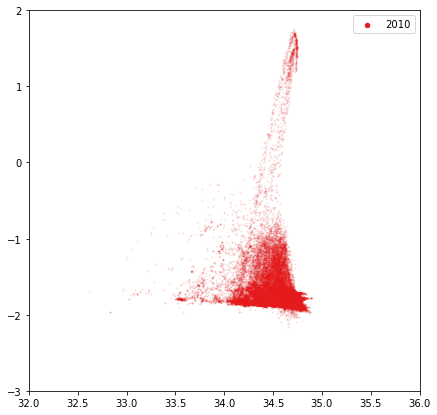

In [62]:
plot_theta_sal.plot_theta_s_yearly(dfmg, Ross&~gline_le_75km, salmin=32, salmax=36, tempmax=2,
                                   years=[2010], alpha=0.1)

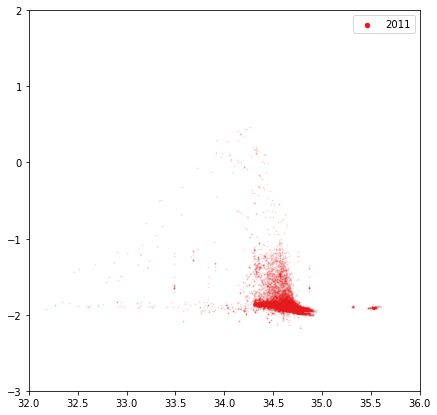

In [61]:
plot_theta_sal.plot_theta_s_yearly(dfmg, Ross&~gline_le_75km, salmin=32, salmax=36, tempmax=2,
                                   years=[2011], alpha=0.1)

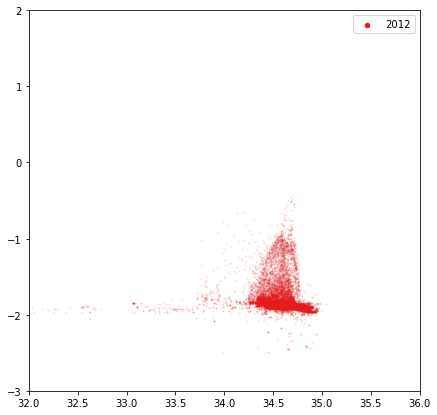

In [63]:
plot_theta_sal.plot_theta_s_yearly(dfmg, Ross&~gline_le_75km, salmin=32, salmax=36, tempmax=2,
                                   years=[2012], alpha=0.1)

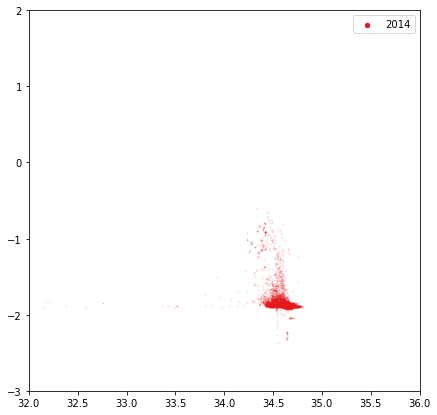

In [64]:
plot_theta_sal.plot_theta_s_yearly(dfmg, Ross&~gline_le_75km, salmin=32, salmax=36, tempmax=2,
                                   years=[2014], alpha=0.1)

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3677: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


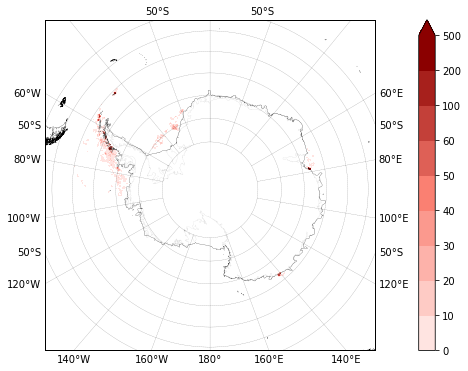

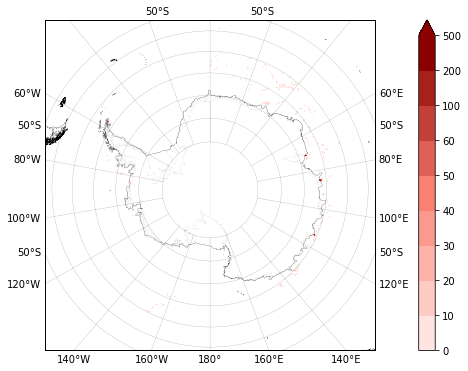

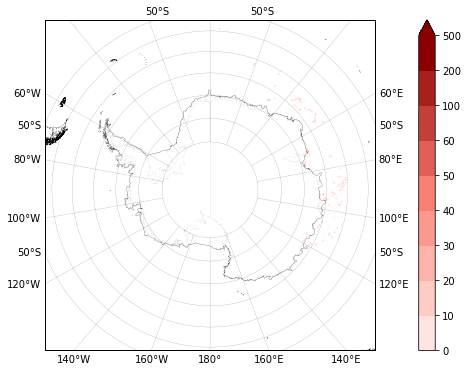

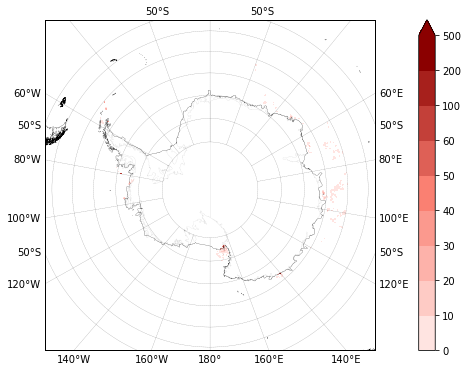

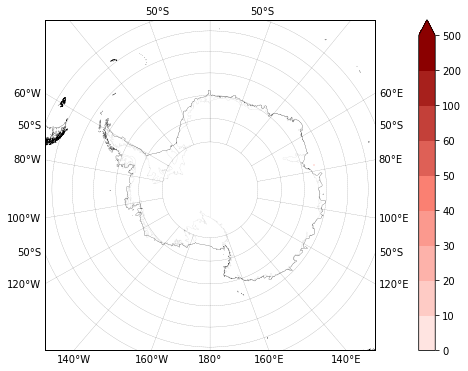

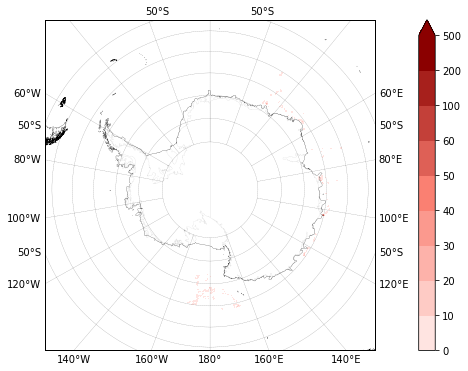

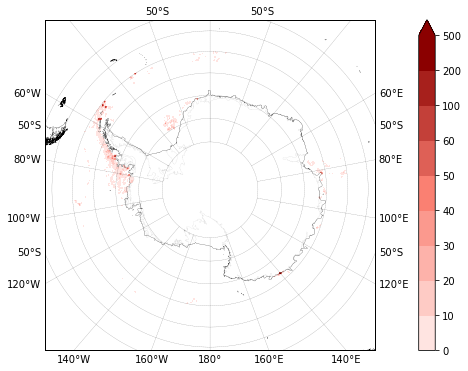

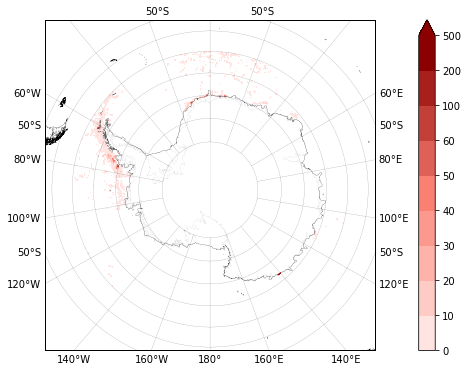

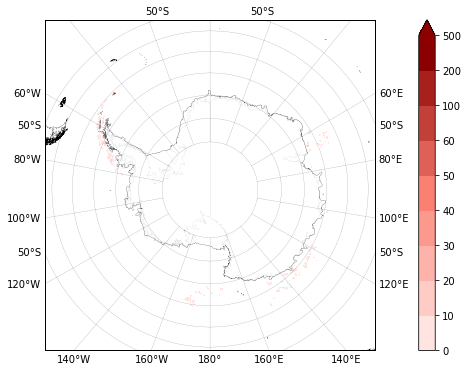

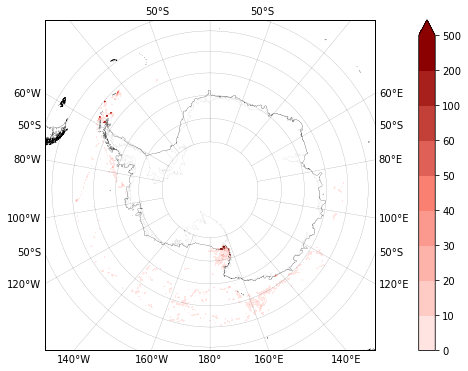

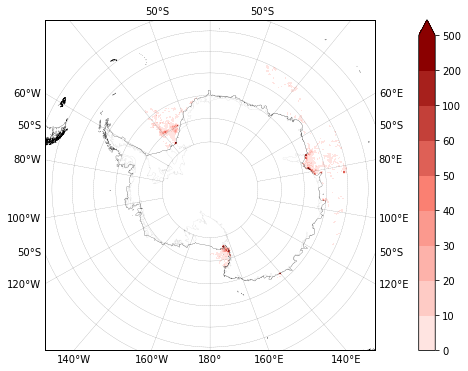

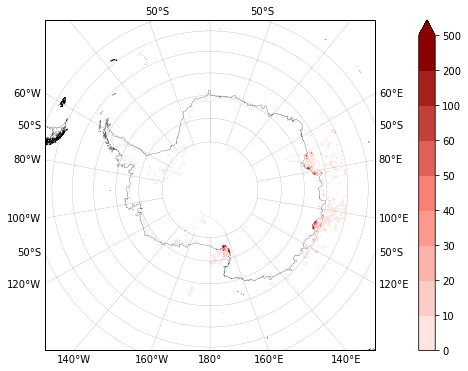

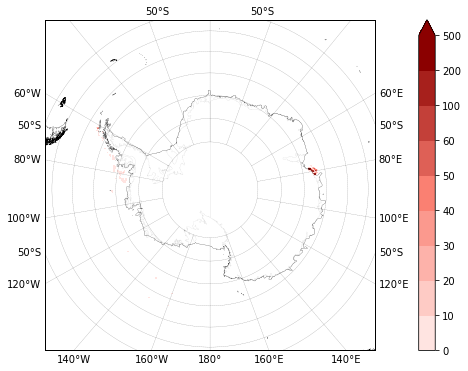

In [124]:
years = dfmg['JULD'].dt.year.unique()
for i in range(len(years)):
    year_mask = dfmg['JULD'].dt.year == years[i]
    topView.plotDataDensity(dfmg[year_mask], show=True, save=True, savename="DataDensity_"+str(years[i])+".png", 
                            levels= [0, 10, 20, 30, 40, 50, 60, 100, 200, 500])

In [700]:
dfmg[Ross].groupby('PROFILE_NUMBER').head(1).DEPTH.quantile(0.01)

-9.895327631355554

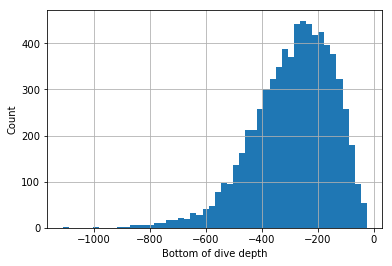

In [76]:
ax = dfmg[Ross&gline_le_75km&deep_mask].groupby('PROFILE_NUMBER').tail(1).DEPTH.hist(bins=50)
ax.set_xlabel("Bottom of dive depth")
ax.set_ylabel("Count")
plt.show()

In [850]:
dfmg.columns

Index(['JULD', 'LATITUDE', 'LONGITUDE', 'PLATFORM_NUMBER', 'POSITION_QC',
       'PRES_ADJUSTED', 'PRES_ADJUSTED_QC', 'PROFILE_NUMBER', 'PSAL_ADJUSTED',
       'PSAL_ADJUSTED_QC', 'TEMP_ADJUSTED', 'TEMP_ADJUSTED_QC', 'DEPTH',
       'DENSITY_INSITU', 'POT_DENSITY', 'CTEMP', 'DENSITY_GRADIENT',
       'ECHODEPTH', 'mab', 'deep_flag', 'DIST_GLINE', 'SA'],
      dtype='object')

In [221]:
import plot_Profiles_vs_time as profile2dTime
importlib.reload(profile2dTime)

<module 'plot_Profiles_vs_time' from '/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_Profiles_vs_time.py'>

In [13]:
dfmg.loc[Ross&gline_le_75km, 'LATITUDE'].describe()

count    301425.000000
mean        -77.183722
std           0.755025
min         -78.259400
25%         -77.694800
50%         -77.366600
75%         -76.907300
max         -72.868500
Name: LATITUDE, dtype: float64

In [12]:
dfmg.loc[Ross&gline_le_75km, 'LONGITUDE'].describe()

count    301425.000000
mean        166.285661
std           2.071870
min         161.051700
25%         165.110800
50%         166.616200
75%         167.203500
max         172.474600
Name: LONGITUDE, dtype: float64

/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_Profiles_vs_time.py:129: RuntimeWarning: invalid value encountered in less
  print(np.mean(conf_int[conf_int < 1e5]))


0.0765915902754 2.14282705854


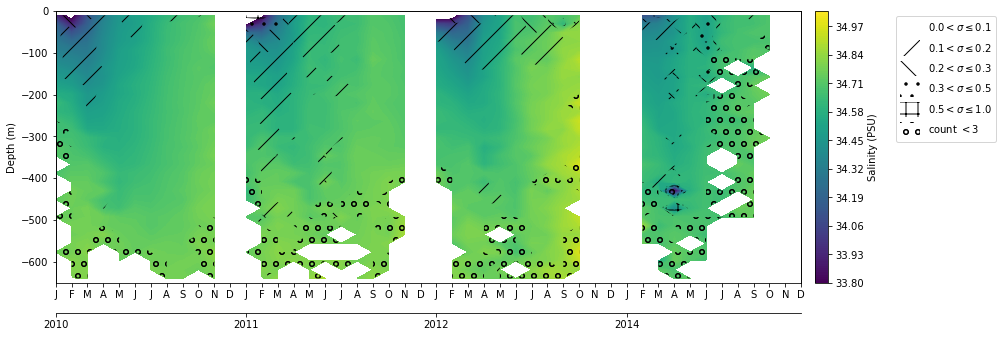

In [216]:
f_h_2, depth_bins = profile2dTime.plot_sal_contours_with_time(dfmg[Ross&gline_le_75km], 
                                          years=[2010, 2011, 2012, 2014], depth_max=-650, zbin=20, 
                                          levs=list(np.arange(33.8, 35.05, 0.01)), save=False, 
                                         savename="./Images/seasonal/RossSalGLle75km.png", type=1, wd=4*4)

In [73]:
for i in range(4):
    print(f_h_1[i, ::-1][0:7].sum())

2669.74208707
2421.60769685
2907.12949698
1453.79136125


In [69]:
f_h_2[:, 0]

array([ 3550.57820487,  2944.1806434 ,  4574.33912801,  1499.74557875])

In [943]:
freshwater_h[0].sum()

5108.6806315791127

/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_Profiles_vs_time.py:129: RuntimeWarning: invalid value encountered in less
  print(np.mean(conf_int[conf_int < 1e5]))


0.0844986459539 0.628937230564


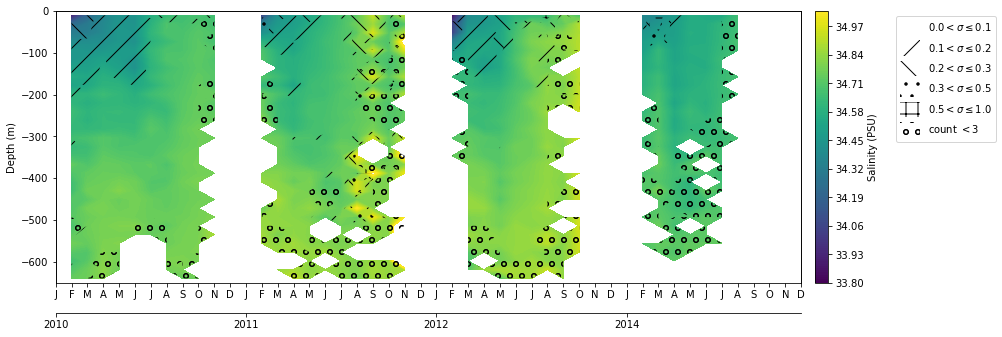

In [218]:
h_f, dbins = profile2dTime.plot_sal_contours_with_time(dfmg[Ross&~gline_le_75km], 
                                          years=[2010, 2011, 2012, 2014], depth_max=-650, zbin=20,
                                         levs=list(np.arange(33.8, 35.05, 0.01)), save=True, 
                                         savename="./Images/seasonal/RossSal_XGLle75km.png", wd=4*4)

In [23]:
h_f[0, ::-1][0:5].sum()

1418.4478140371014

/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_Profiles_vs_time.py:129: RuntimeWarning: invalid value encountered in less
  print(np.mean(conf_int[conf_int < 1e5]))


0.0377830089712 0.116036586175


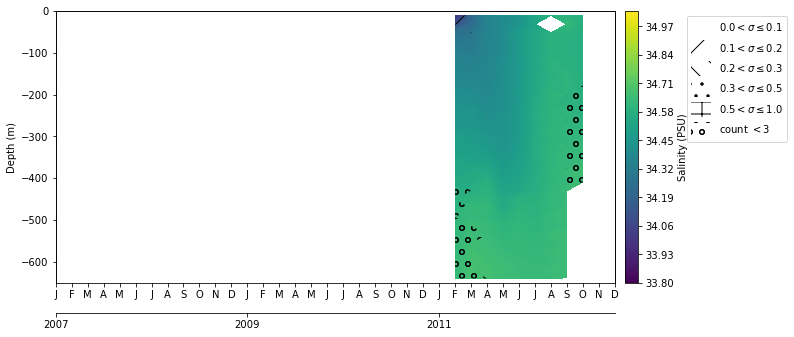

In [219]:
h_f_Weddell_gl_le75km, dl = profile2dTime.plot_sal_contours_with_time(dfmg[Weddell&gline_le_75km], 
                                          years=[2007, 2009, 2011], depth_max=-650, zbin=20,
                                         levs=list(np.arange(33.8, 35.05, 0.01)), save=True,
                                         savename="./Images/seasonal/WeddellSalGLle75km.png", wd=4*3)

In [210]:
h_f_Weddell_gl_le75km[::-1][0:7].sum()

3601.815535376852

In [212]:
dl[::-1][6]

-125.80645161290317

In [223]:
importlib.reload(profile2dTime)

<module 'plot_Profiles_vs_time' from '/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_Profiles_vs_time.py'>

/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_Profiles_vs_time.py:229: RuntimeWarning: invalid value encountered in less


0.0619736955372 0.360783310816


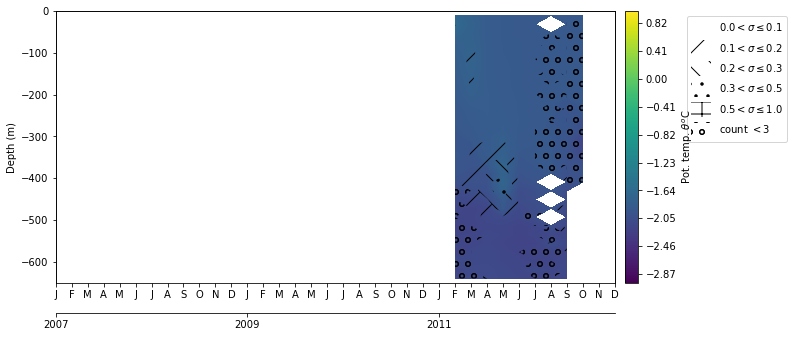

In [227]:
profile2dTime.plot_CT_contours_with_time(dfmg[Weddell&gline_le_75km], 
                                          years=[2007, 2009, 2011], depth_max=-650, zbin=20,
                                         levs=list(np.arange(-3, 1.01, 0.01)), save=True,
                                         savename="./Images/seasonal/WeddellCTGLle75km.png", wd=4*3)

/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_Profiles_vs_time.py:129: RuntimeWarning: invalid value encountered in less
  print(np.mean(conf_int[conf_int < 1e5]))


0.0747756180677 0.355029407441


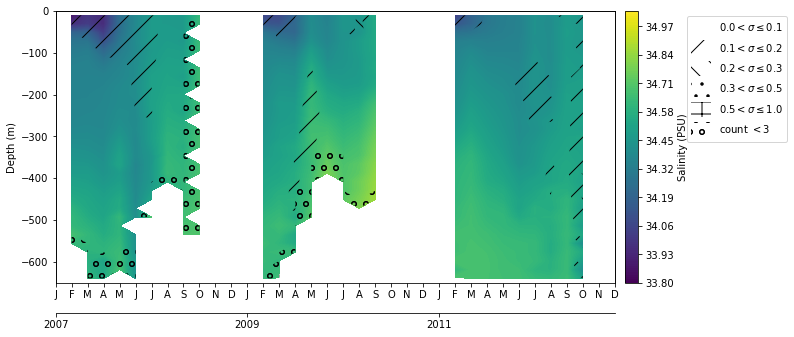

In [220]:
hf_Weddell_Xclude_gl75km, dl = profile2dTime.plot_sal_contours_with_time(dfmg[Weddell&~gline_le_75km], 
                                          years=[2007, 2009, 2011], depth_max=-650, zbin=20,
                                         levs=list(np.arange(33.8, 35.05, 0.01)), save=True,
                                         savename="./Images/seasonal/WeddellSal_XGLle75km.png", wd= 4*3)

/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_Profiles_vs_time.py:229: RuntimeWarning: invalid value encountered in less


0.354475588333 1.55549552656


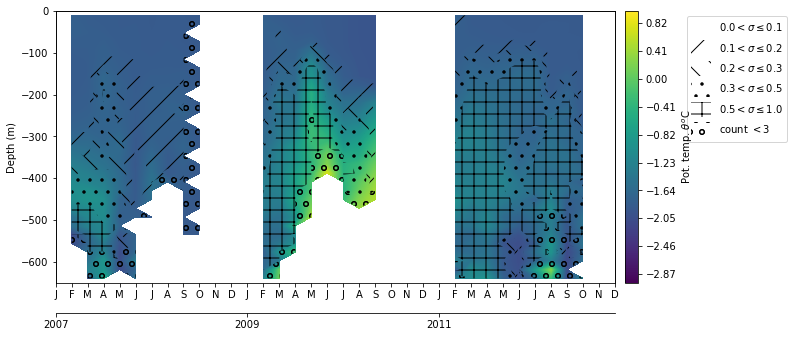

In [228]:
profile2dTime.plot_CT_contours_with_time(dfmg[Weddell&~gline_le_75km], 
                                          years=[2007, 2009, 2011], depth_max=-650, zbin=20,
                                         levs=list(np.arange(-3, 1.01, 0.01)), save=True,
                                         savename="./Images/seasonal/WeddellCT_XGLle75km.png", wd= 4*3)

/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_Profiles_vs_time.py:129: RuntimeWarning: invalid value encountered in less
  print(np.mean(conf_int[conf_int < 1e5]))


0.0646220133027 0.326079455653


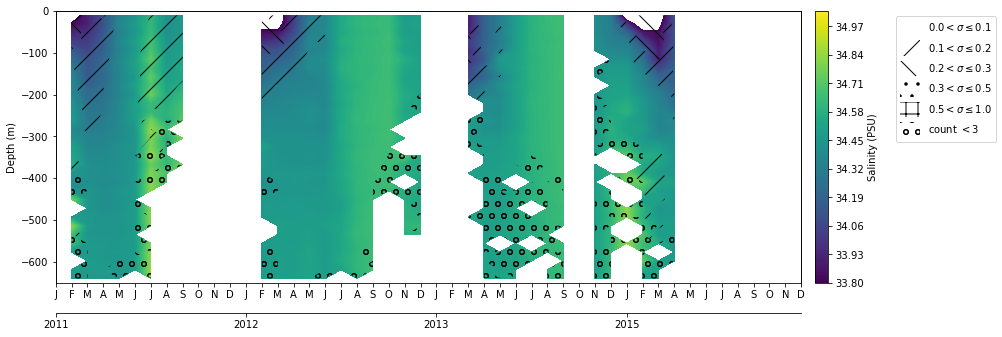

In [232]:
hf_Prydzle75km, dl = profile2dTime.plot_sal_contours_with_time(dfmg[Prydz&gline_le_75km], 
                                          years=[2011, 2012, 2013, 2015], depth_max=-650, zbin=20,
                                         levs=list(np.arange(33.8, 35.05, 0.01)), save=True,
                                         savename="./Images/seasonal/PrydzSalGLle75km.png", wd=4*4)

In [ ]:
profile2dTime.plot_CT_contours_with_time(dfmg[Prydz&gline_le_75km], 
                                          years=[2011, 2012, 2013, 2015], depth_max=-650, zbin=20,
                                         levs=list(np.arange(33.8, 35.05, 0.01)), save=True,
                                         savename="./Images/seasonal/PrydzSalGLle75km.png", wd=4*4)

0.0736226848042


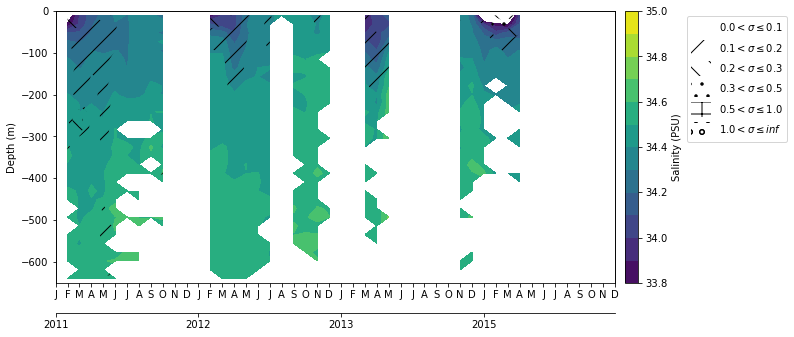

In [841]:
profile2dTime.plot_sal_contours_with_time(dfmg[Prydz&~gline_le_75km], 
                                          years=[2011, 2012, 2013, 2015], depth_max=-650, zbin=20,
                                         levs=list(np.arange(33.8, 35.05, 0.1)), save=True,
                                         savename="./Images/seasonal/PrydzSal_XGLle75km.png")

In [193]:
importlib.reload(profDist)

<module 'plot_profiles_vs_dist' from '/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_profiles_vs_dist.py'>

/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_profiles_vs_dist.py:19: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  depth_bins = np.linspace(zlowest, 0, number_bins)
/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_profiles_vs_dist.py:61: RuntimeWarning: invalid value encountered in less
  print(np.max(conf_int[conf_int < 1e5]))


0.530508036241


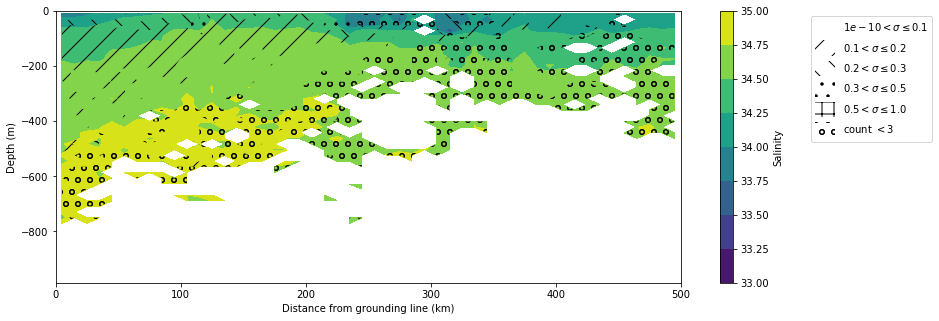

In [194]:
mask = Ross & sel_months(dfmg, [1,2,3])
profDist.plot_var_contours_with_distance(dfmg, mask=mask, var='PSAL_ADJUSTED', dist=500, 
                                colorunit='Salinity', save=True, 
                                savename='./Images/profDist/Ross_JFM.png', wd=14, ht=5, 
                                zmin=0, zbin=20, xbin=10)

/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_profiles_vs_dist.py:19: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  depth_bins = np.linspace(zlowest, 0, number_bins)


0.647073484517


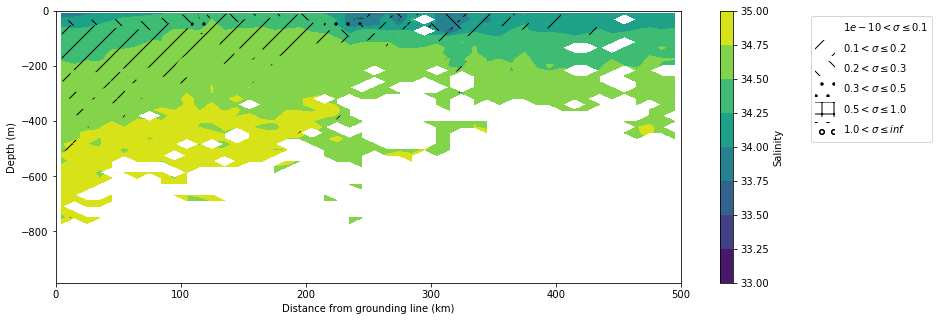

In [117]:
mask = Ross & sel_months(dfmg, [2,3])
profDist.plot_var_contours_with_distance(dfmg, mask=mask, var='PSAL_ADJUSTED', dist=500, 
                                colorunit='Salinity', save=True, 
                                savename='./Images/profDist/Ross_FM.png', wd=14, ht=5, 
                                zmin=0, zbin=20, xbin=10)

/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_profiles_vs_dist.py:19: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  depth_bins = np.linspace(zlowest, 0, number_bins)


4.34670318691


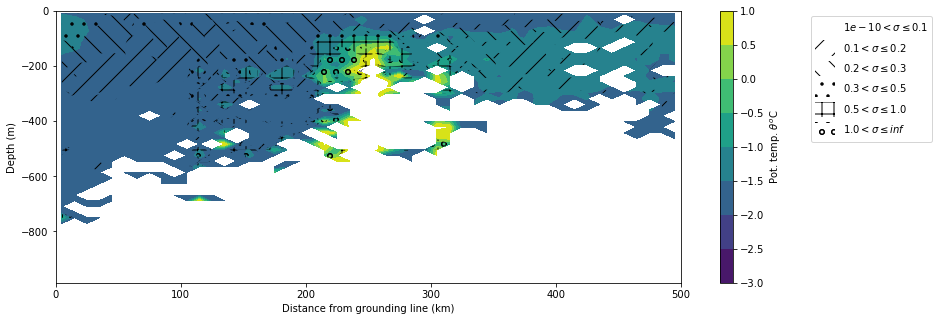

In [127]:
mask = Ross & sel_months(dfmg, [2,3])
profDist.plot_var_contours_with_distance(dfmg, mask=mask, var='CTEMP', dist=500, 
                                colorunit='Pot. temp. $\\theta^o$C', save=True, 
                                savename='./Images/profDist/Ross_CTEMP_FM.png', wd=14, ht=5, 
                                zmin=0, zbin=20, xbin=10, varmin=-3, varmax=1)

/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_profiles_vs_dist.py:19: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  depth_bins = np.linspace(zlowest, 0, number_bins)


0.639224055451


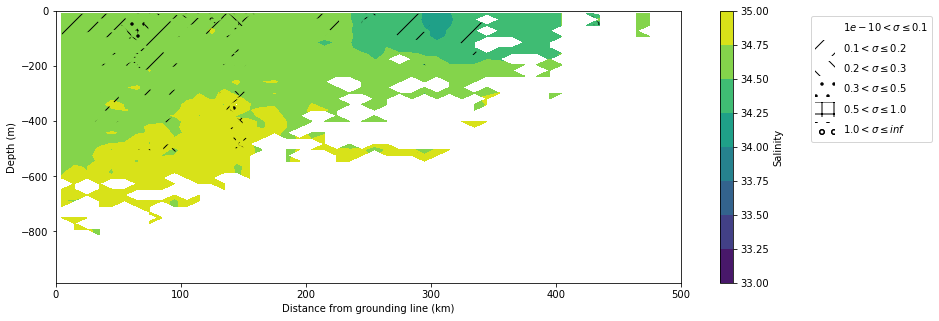

In [118]:
mask = Ross & sel_months(dfmg, [6,7,8])
profDist.plot_var_contours_with_distance(dfmg, mask=mask, var='PSAL_ADJUSTED', dist=500, 
                                colorunit='Salinity', save=True, 
                                savename='./Images/profDist/Ross_JJA.png', wd=14, ht=5, 
                                zmin=0, zbin=20, xbin=10)

/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_profiles_vs_dist.py:19: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  depth_bins = np.linspace(zlowest, 0, number_bins)


0.835200327413


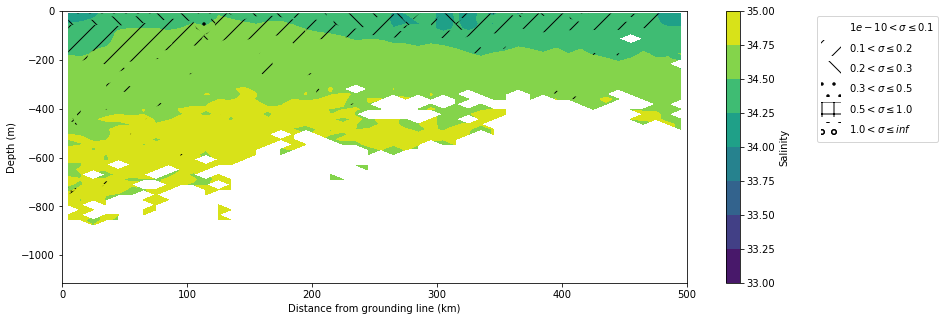

In [119]:
mask = Ross & sel_months(dfmg, [1,2,3,4,5])
profDist.plot_var_contours_with_distance(dfmg, mask=mask, var='PSAL_ADJUSTED', dist=500, 
                                colorunit='Salinity', save=True, 
                                savename='./Images/profDist/Ross_JFMAM.png', wd=14, ht=5, 
                                zmin=0, zbin=20, xbin=10)

/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_profiles_vs_dist.py:19: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  depth_bins = np.linspace(zlowest, 0, number_bins)


0.641571789698


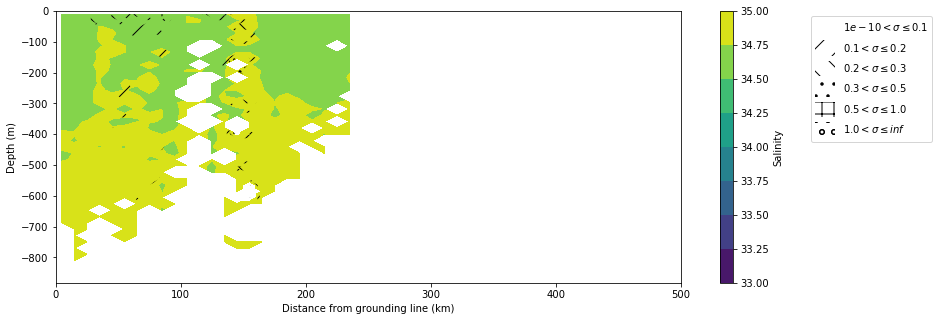

In [120]:
mask = Ross & sel_months(dfmg, [9,10,11])
profDist.plot_var_contours_with_distance(dfmg, mask=mask, var='PSAL_ADJUSTED', dist=500, 
                                colorunit='Salinity', save=True, 
                                savename='./Images/profDist/Ross_SON.png', wd=14, ht=5, 
                                zmin=0, zbin=20, xbin=10)

/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_profiles_vs_dist.py:19: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  depth_bins = np.linspace(zlowest, 0, number_bins)


0.208345547077


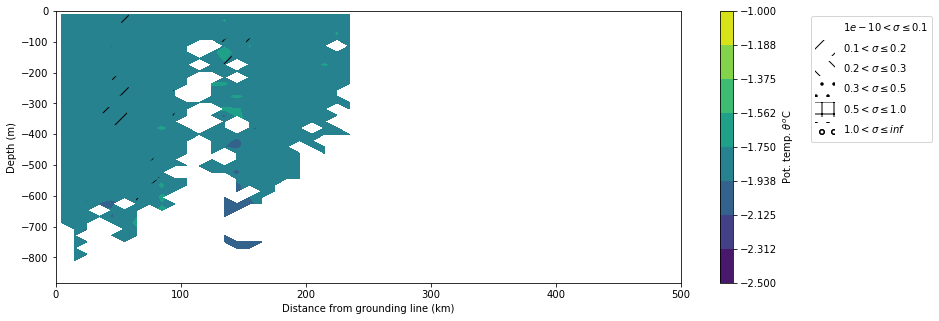

In [130]:
mask = Ross & sel_months(dfmg, [9,10,11])
profDist.plot_var_contours_with_distance(dfmg, mask=mask, var='CTEMP', dist=500, 
                                colorunit='Pot. temp. $\\theta^o$C', save=True, 
                                savename='./Images/profDist/Ross_CTEMP_SON.png', wd=14, ht=5, 
                                zmin=0, zbin=20, xbin=10, varmin=-2.5, varmax=-1)

/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_profiles_vs_dist.py:19: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  depth_bins = np.linspace(zlowest, 0, number_bins)


0.639224055451


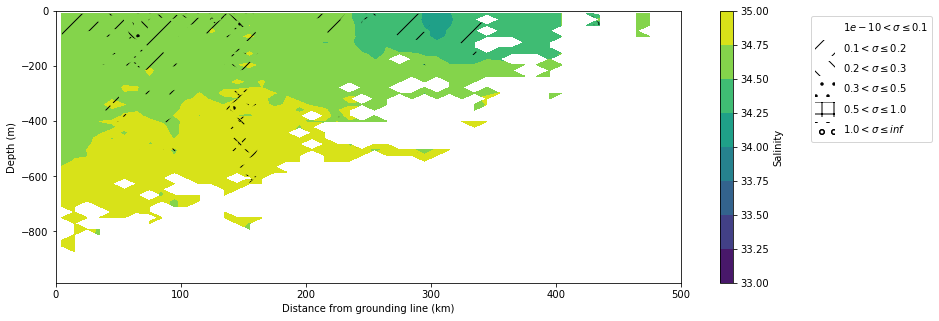

In [121]:
mask = Ross & sel_months(dfmg, [6,7,8,9,10,11])
profDist.plot_var_contours_with_distance(dfmg, mask=mask, var='PSAL_ADJUSTED', dist=500, 
                                colorunit='Salinity', save=True, 
                                savename='./Images/profDist/Ross_JJASON.png', wd=14, ht=5, 
                                zmin=0, zbin=20, xbin=10)

/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_profiles_vs_dist.py:19: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  depth_bins = np.linspace(zlowest, 0, number_bins)


0.235334717021


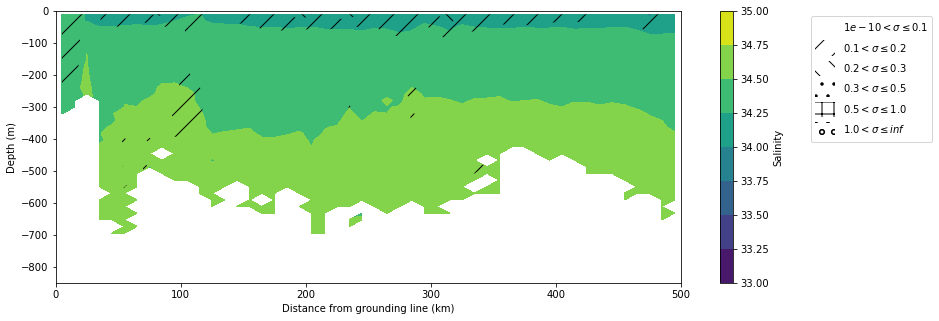

In [122]:
mask = Weddell & sel_months(dfmg, [2,3])
profDist.plot_var_contours_with_distance(dfmg, mask=mask, var='PSAL_ADJUSTED', dist=500, 
                                colorunit='Salinity', save=True, 
                                savename='./Images/profDist/Weddell_FM.png', wd=14, ht=5, 
                                zmin=0, zbin=20, xbin=10, nlevs=9)

In [123]:
np.linspace(-3, 1, 9)

array([-3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ])

/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_profiles_vs_dist.py:19: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  depth_bins = np.linspace(zlowest, 0, number_bins)


1.70105633092


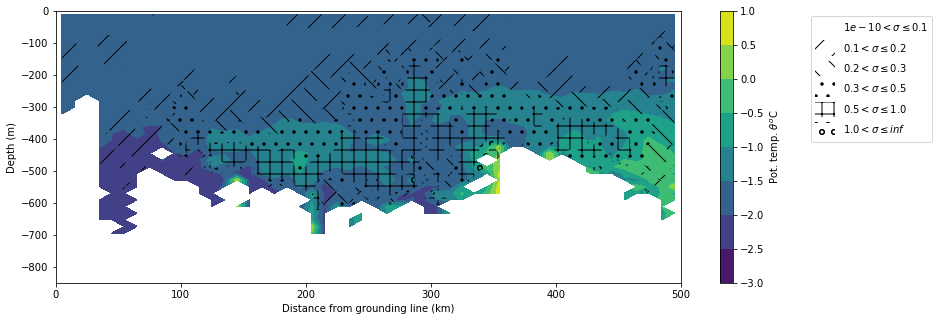

In [124]:
mask = Weddell & sel_months(dfmg, [2,3])
profDist.plot_var_contours_with_distance(dfmg, mask=mask, var='CTEMP', dist=500, 
                                colorunit='Pot. temp. $\\theta^o$C', save=True, 
                                savename='./Images/profDist/Weddell_CTEMP_FM.png', wd=14, ht=5, 
                                zmin=0, zbin=20, xbin=10, varmin=-3, varmax=1, nlevs=9)

/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_profiles_vs_dist.py:19: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  depth_bins = np.linspace(zlowest, 0, number_bins)


0.515398808624


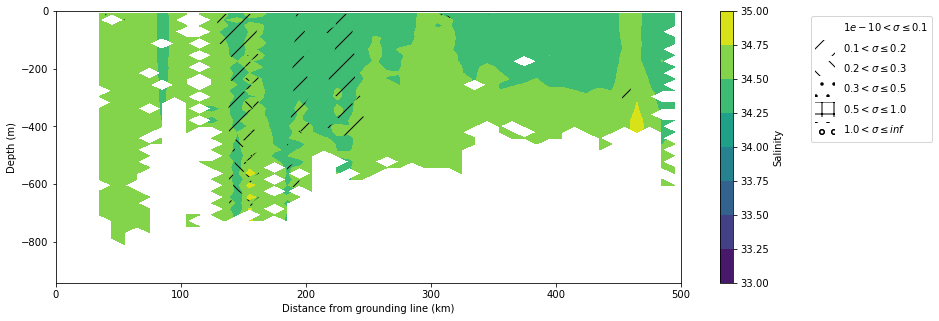

In [125]:
mask = Weddell & sel_months(dfmg, [9,10])
profDist.plot_var_contours_with_distance(dfmg, mask=mask, var='PSAL_ADJUSTED', dist=500, 
                                colorunit='Salinity', save=True, 
                                savename='./Images/profDist/Weddell_SO.png', wd=14, ht=5, 
                                zmin=0, zbin=20, xbin=10)

/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_profiles_vs_dist.py:19: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  depth_bins = np.linspace(zlowest, 0, number_bins)


1.52891085846


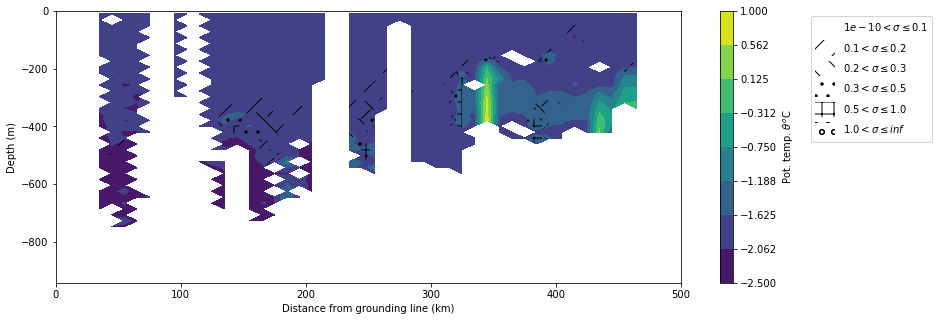

In [133]:
mask = Weddell & sel_months(dfmg, [9,10])
profDist.plot_var_contours_with_distance(dfmg, mask=mask, var='CTEMP', dist=500, 
                                colorunit='Pot. temp. $\\theta^o$C', save=True, 
                                savename='./Images/profDist/Weddell_CTEMP_SO.png', wd=14, ht=5, 
                                zmin=0, zbin=20, xbin=10, varmin=-2.5, varmax=1)

/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_profiles_vs_dist.py:19: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  depth_bins = np.linspace(zlowest, 0, number_bins)


0.864809577408


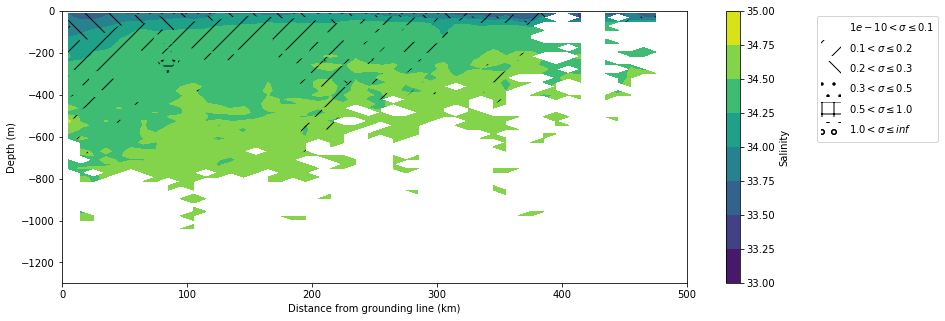

In [126]:
mask = Prydz & sel_months(dfmg, [2,3])
profDist.plot_var_contours_with_distance(dfmg, mask=mask, var='PSAL_ADJUSTED', dist=500, 
                                colorunit='Salinity', save=True, 
                                savename='./Images/profDist/Prydz_FM.png', wd=14, ht=5, 
                                zmin=0, zbin=20, xbin=10)